In [1]:
# Initialisations

library(rJava)
library(ggplot2)
library(corrplot)
library(cluster)
library(factoextra)
library(xlsx)
library(reshape2)
library(rpart)
library(rpart.plot)
theme_set(theme_classic())

corrplot 0.84 loaded
Welcome! Related Books: `Practical Guide To Cluster Analysis in R` at https://goo.gl/13EFCZ
Loading required package: xlsxjars


In [2]:
# Plot Functions

adenome_scatterplot <- function(df, feature_1, feature_2, f1, f2) {
  x_axis = f1
  y_axis = f2
  title = "RTUPB/VBPPS"
  subtitle = paste(x_axis, " Vs. ", y_axis)
  g <- ggplot(df, aes(x=feature_1, y=feature_2))
  g <- g + geom_point()
  g <- g + labs(title=title,y=y_axis,x=x_axis)
  print(g)
}

# Obtenir le triangle inférieur d'une matrice
get_lower_tri <- function(mat){
    mat[upper.tri(mat)] <- NA
    return(mat)
}

# Obtenir le triangle supérieur d'une matrice
get_upper_tri <- function(mat){
    mat[lower.tri(mat)] <- NA
    return(mat)
}

# Re-ordonne la matrice de corrélation
reorder_cormat <- function(cormat){
    # Utiliser la corrélation entre les variables
    # comme mesure de distance
    dd <- as.dist((1-cormat)/2)
    hc <- hclust(dd)
    cormat <- cormat[hc$order, hc$order]
}

adenome_heatmap <- function(cormat) { 
    # Reordonner la matrice de corrélation
    cormat <- reorder_cormat(cormat)
    upper_tri <- get_upper_tri(cormat)
    # Fondre la matrice de corrélation
    melted_cormat <- melt(upper_tri, na.rm = TRUE)
    # Créer le heatmap
    ggheatmap <- ggplot(melted_cormat, aes(Var2, Var1, fill = value))+
        geom_tile(color = "white")+
        scale_fill_gradient2(low = "blue", high = "red", mid = "white", 
        midpoint = 0, limit = c(-1,1), space = "Lab",
        name="Pearson\nCorrelation") +
        theme_minimal()+ # minimal theme
        theme(axis.text.x = element_text(angle = 45, vjust = 1, 
        size = 12, hjust = 1))+
        coord_fixed()
    
    ggheatmap <- ggheatmap + 
    geom_text(aes(Var2, Var1, label = round(value,3)), color = "black", size = 3) +
    theme(
      axis.title.x = element_blank(),
      axis.title.y = element_blank(),
      panel.grid.major = element_blank(),
      panel.border = element_blank(),
      panel.background = element_blank(),
      axis.ticks = element_blank(),
      legend.justification = c(1, 0),
      legend.position = c(0.6, 0.7),
      legend.direction = "horizontal")+
      guides(fill = guide_colorbar(barwidth = 7, barheight = 1,
                title.position = "top", title.hjust = 0.5))
    
    # Afficher heatmap
    print(ggheatmap)
}

In [3]:
# Import du dataset complet XLSX
rtupb_vbpps_complete <- read.xlsx(file = "datasets/RTUPB-VBPPS.xlsx", sheetIndex = 1, header = 1, startRow = 2)[,-1]
attributes(rtupb_vbpps_complete)$names = c('Age','Comorbidite','Duree_Traitement_Medical','Porteur_Sonde','IPSS','QoL','Qmax','PSA','Volume_Prostatique','Residu_Post_Mictionnel','Indication','Anesthesie','Evenement','Technique','Transfusion','Temps_Operation','Volume_Reseque','Delai_Ablation','Caillotage','Reprise_Bloc',
    'M1_IPSS','M1_QoL','M1_Qmax','M3_IPSS','M3_QoL','M3_Qmax','M6_IPSS','M6_QoL','M6_Qmax','M9_IPSS','M9_QoL','M9_Qmax','M12_IPSS','M12_QoL','M12_Qmax','M15_IPSS','M15_QoL','M15_Qmax','M18_IPSS','M18_QoL','M18_Qmax')

# 1. Considérations

## 1.1 Typage des données

Pour le typage des données, nous avons fait le choix de garder les variables numériques par défaut sauf pour certaines variables que nous avons voulu traiter en tant que Variable Qualitative (= "factor") :
- Comorbidite
- Porteur sonde
- Caillotage
- Transfusion
- Reprise bloc
- Anesthesie
- Indication
- Evenement
- Technique

Les variables "QoL" peuvent être considérées comme des variables ordinales car la "Qualité de vie" est 1 score donné par le patient de 1 à 7. Plus il est élevé, plus le patient est insatisfait. Toutefois nous avons choisi de le traiter en tant que variable quantitative car nous allons établir des prédictions pour ce score dans la partie clustering. Il en va de même pour la variable IPSS. Pour celle-ci la valeur numérique a encore plus de sens car elle est une addition de différents scores concernant le patient.

In [4]:
# Cast des variables catégoriques
rtupb_vbpps_complete$Comorbidite<-as.factor(rtupb_vbpps_complete$Comorbidite)
rtupb_vbpps_complete$Porteur_Sonde<-as.factor(rtupb_vbpps_complete$Porteur_Sonde)
rtupb_vbpps_complete$Caillotage<-as.factor(rtupb_vbpps_complete$Caillotage)
rtupb_vbpps_complete$Transfusion<-as.factor(rtupb_vbpps_complete$Transfusion)
rtupb_vbpps_complete$Reprise_Bloc<-as.factor(rtupb_vbpps_complete$Reprise_Bloc)
rtupb_vbpps_complete$Anesthesie<-as.factor(rtupb_vbpps_complete$Anesthesie)
rtupb_vbpps_complete$Indication<-as.factor(rtupb_vbpps_complete$Indication)
rtupb_vbpps_complete$Evenement<-as.factor(rtupb_vbpps_complete$Evenement)
rtupb_vbpps_complete$Technique<-as.factor(rtupb_vbpps_complete$Technique)

## 1.2  Données manquantes

Les individus porteur de sonde ne sont pas concernés par la variable 'Résidu post mictionnel'. En effet, les porteurs de sonde n'urinent pas par voie naturelle, la sonde faisant le travail mécanique de vider la vessie. Ils n'ont donc pas de valeurs pour cette feature dans le jeu de données originel. 
Ici, plusieurs scénarios sont possibles. On pourrait, par exemple, enlever la variable 'Résidu post mictionnel' ou alors baser notre analyse uniquement sur les patients qui ne sont pas porteurs de sonde.

Le jeu de données n'étant pas très important, nous faisons le choix de ne pas enlever d'individus. Nous enlèverons donc la variable 'Résidu Post mictionnel' ainsi que la variable 'Qmax' qui n'est pas relevée pour les individus porteurs de sonde.

De plus le volume réséqué n'est disponible que pour la technique opératoire RTUPB. En effet, cette opération consiste en la résurection transurétrale de la prostate alors que la technique VBPPS n'enlève pas de tissu prostatique. Nous pensons que cette donnée va fausser l'analyse et ne sera pas pertinente dans la discrimination des techniques opératoires. Nous faisons le choix de la supprimer également.

Enfin, nous avons noté que certaines variables sont constantes à tout le tableau : 'Evenement', 'Transfusion' et 'Reprise Bloc'. Nous faisons le choix de les supprimer malgré que cela pourrait poser un problème dans l'éventualité où des nouveaux patients seraient intégrés à l'étude avec des valeurs différentes de celles aujourd'hui observées.

Résumé : Jeu de données complet 
   \- moins Résidu post mictionnel
   \- moins Volume Réséqué
   \- moins Qmax
   \- moins Evenement
   \- moins Transfusion
   \- moins Reprise Bloc

### 1.3 Individus dupliqués ?

Nous notons que certains individus sont étrangement proches, avec 1 valeur différente sur 1 seule variable ou parfois toutes les variables avec les mêmes valeurs.

Par exemple, les 3 individus ci-dessous ont les mêmes valeurs pour toutes les variables.

In [5]:
rtupb_vbpps_complete[c(17,30,36),]

,Age,Comorbidite,Duree_Traitement_Medical,Porteur_Sonde,IPSS,QoL,Qmax,PSA,Volume_Prostatique,Residu_Post_Mictionnel,⋯,M9_Qmax,M12_IPSS,M12_QoL,M12_Qmax,M15_IPSS,M15_QoL,M15_Qmax,M18_IPSS,M18_QoL,M18_Qmax
17,84,0,11,1,35,6,0,1.23,67,NA,⋯,18.1,2,2,18.1,2,2,17.9,2,2,17.9
30,84,0,11,1,35,6,0,1.23,67,NA,⋯,18.1,2,2,18.1,2,2,17.9,2,2,17.9
36,84,0,11,1,35,6,0,1.23,67,NA,⋯,18.1,2,2,18.1,2,2,17.9,2,2,17.9


Autre exemple, les individus ci-dessous ont les mêmes valeurs pour toutes les variables, sauf l'âge et le résidu post-mictionnel.

In [6]:
rtupb_vbpps_complete[c(2,32),]

,Age,Comorbidite,Duree_Traitement_Medical,Porteur_Sonde,IPSS,QoL,Qmax,PSA,Volume_Prostatique,Residu_Post_Mictionnel,⋯,M9_Qmax,M12_IPSS,M12_QoL,M12_Qmax,M15_IPSS,M15_QoL,M15_Qmax,M18_IPSS,M18_QoL,M18_Qmax
2,85,1,82,0,31,5,5.9,1.19,43,120,⋯,14.2,1,1,14.2,1,1,14.4,1,1,14.4
32,86,1,82,0,31,5,5.9,1.19,43,180,⋯,14.2,1,1,14.2,1,1,14.4,1,1,14.4


 Dans une situation réelle nous aurions demandé au client de faire la lumière sur ce jeu de données et de vérifier qu'il n'y a pas d'erreur. Ces individus ont également des valeurs éloignées de la moyenne sur certaines features. Ils vont probablement compromettre le clustering mais nous faisons le choix de les garder quand même car rien ne nous indique à ce niveau que ce sont des erreurs.

In [7]:
# Préparation du jeu de données

# on garde tous les individus
# on supprime les features que nous avons choisies d'ignorer
rtupb_vbpps <- subset(rtupb_vbpps_complete,select=-c(Volume_Reseque,Residu_Post_Mictionnel,Qmax,Evenement,Transfusion,Reprise_Bloc))

In [8]:
# 14 premières colonnes du dataset -> pré-opératoire, les dernières -> post-opératoire
rtupb_vbpps_pre <- rtupb_vbpps[,1:14]
rtupb_vbpps_post <- rtupb_vbpps[,c(11,15:35)]

In [9]:
# On crée des dataframes ne comportant que les variables numériques (pour corrélation linéaire de Pearson)
rtupb_vbpps_num <- rtupb_vbpps[,sapply(rtupb_vbpps, function(x) is.numeric(x))]
rtupb_vbpps_pre_num = rtupb_vbpps_pre[,sapply(rtupb_vbpps_pre, function(x) is.numeric(x))]
rtupb_vbpps_post_num = rtupb_vbpps_post[,sapply(rtupb_vbpps_post, function(x) is.numeric(x))]

# On crée des dataframes ne comportant que les données booléennes, ordinales ou catégoriques
rtupb_vbpps_cat <- rtupb_vbpps[,sapply(rtupb_vbpps, function(x) is.ordered(x) | is.factor(x) | is.logical(x))]
rtupb_vbpps_pre_cat = rtupb_vbpps_pre[,sapply(rtupb_vbpps_pre, function(x) is.ordered(x) | is.factor(x) | is.logical(x))]

# 2. Analyse descriptive

## 2.1 Analyse descriptive - Pré-opératoire

### 2.1.2 Distributions

### a. Sous-populations
Pour commencer, il nous a paru important de comprendre le découpage de la population sur certains axes : "Technique" et "Porteur de sonde".

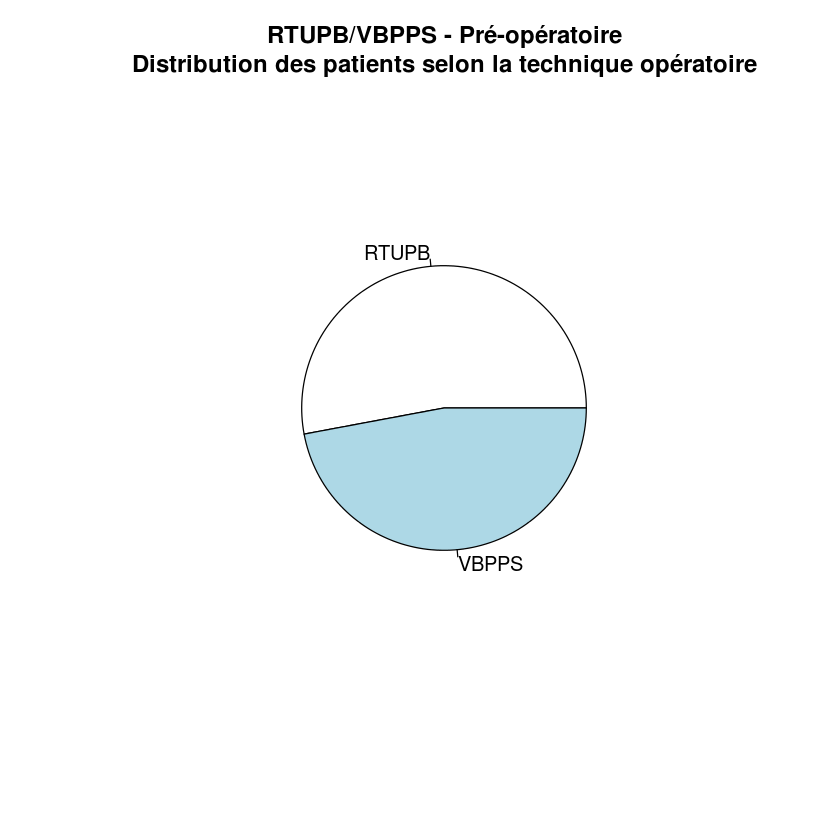

In [10]:
t <- table(rtupb_vbpps_complete$Technique)
pie(x = t, labels = c("RTUPB","VBPPS"),main = "RTUPB/VBPPS - Pré-opératoire\nDistribution des patients selon la technique opératoire", radius = 0.5)

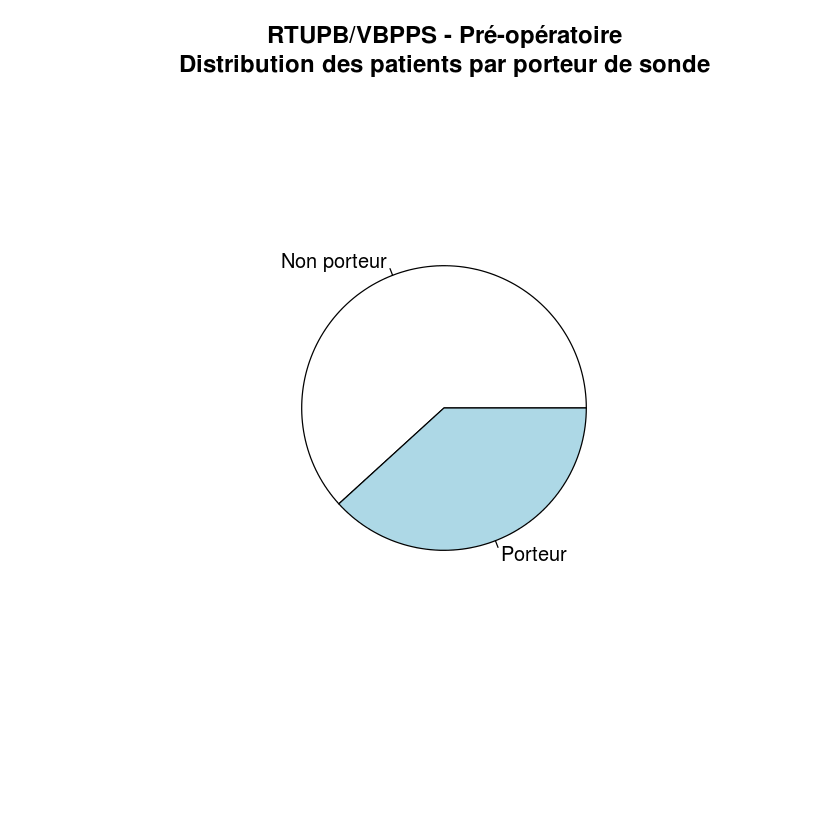

In [11]:
t <- table(rtupb_vbpps_complete$Porteur_Sonde)
pie(x = t, labels = c("Non porteur","Porteur"),main = "RTUPB/VBPPS - Pré-opératoire\nDistribution des patients par porteur de sonde", radius = 0.5)

### b. Par variables et par Technique
Pour chaque variable, nous avons fait le choix de visualiser les distributions globalement et aussi dans les sous-populations des techniques "RTUPB" et "VBPPS".

In [12]:
# on divise le dataset en 2 pour voir les techniques séparément
rtupb_pre <- rtupb_vbpps_pre[which(rtupb_vbpps_pre$Technique == 1),]
vbpps_pre <- rtupb_vbpps_pre[which(rtupb_vbpps_pre$Technique == 2),]

rtupb_pre_num <- rtupb_pre[,sapply(rtupb_pre, function(x) is.numeric(x))]
vbpps_pre_num <- vbpps_pre[,sapply(vbpps_pre, function(x) is.numeric(x))]

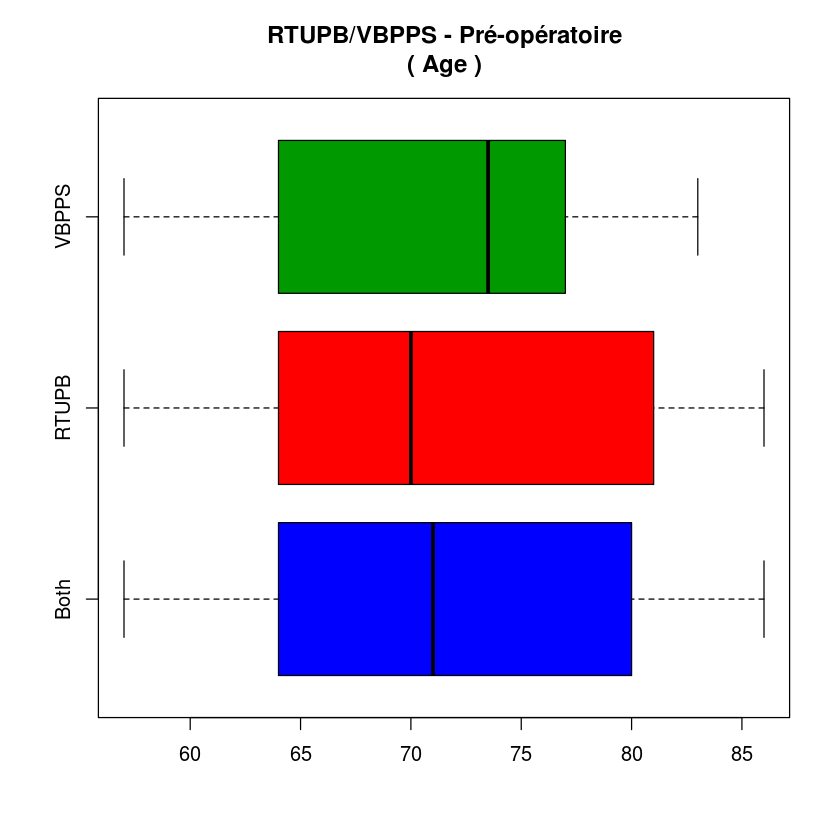

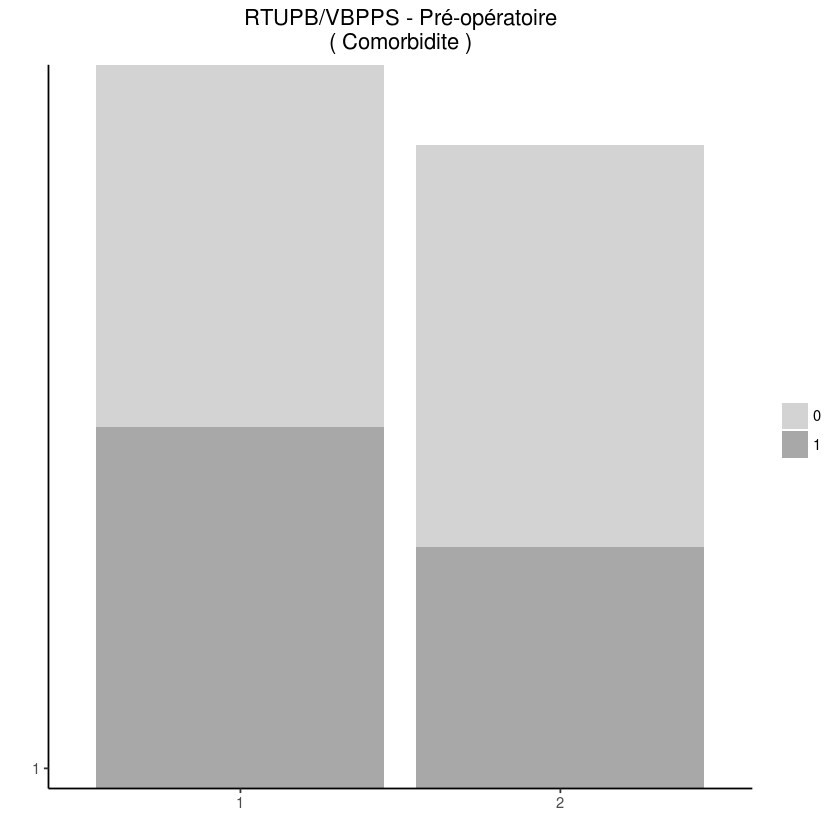

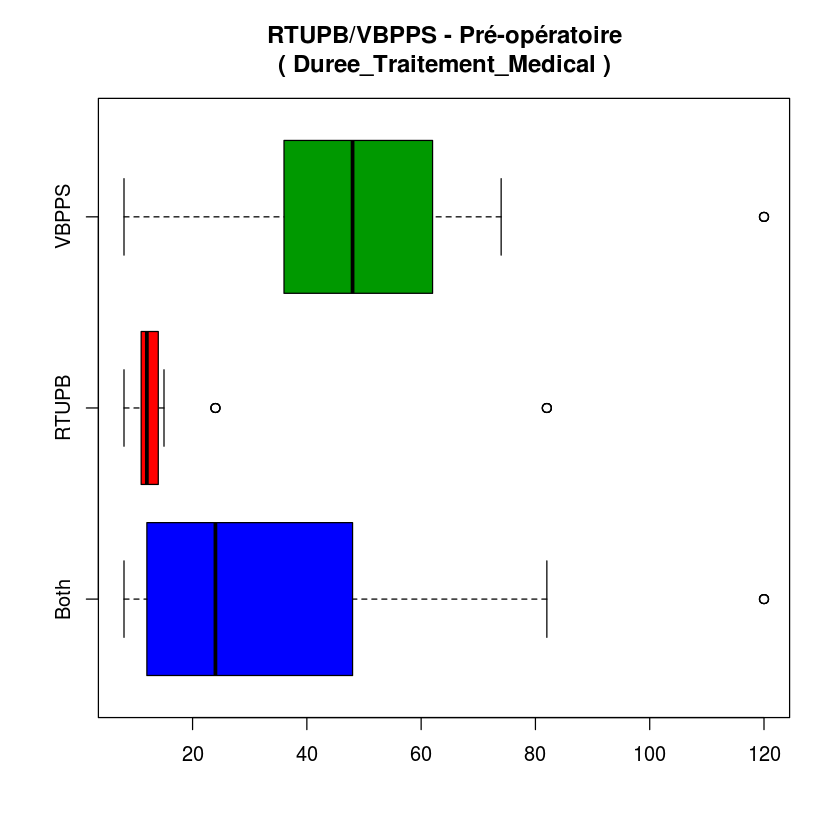

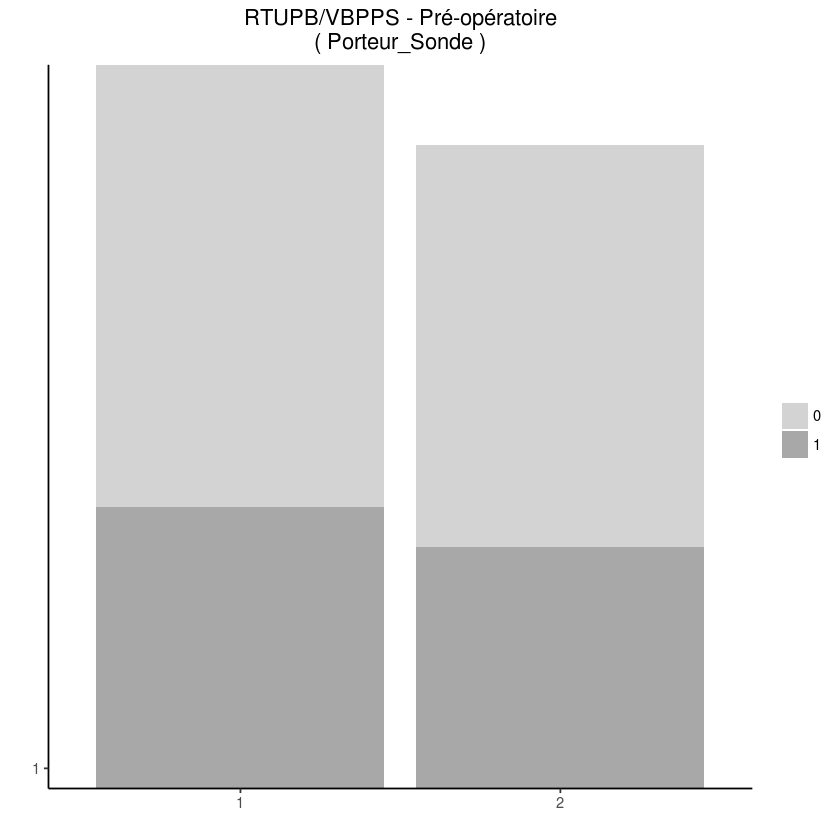

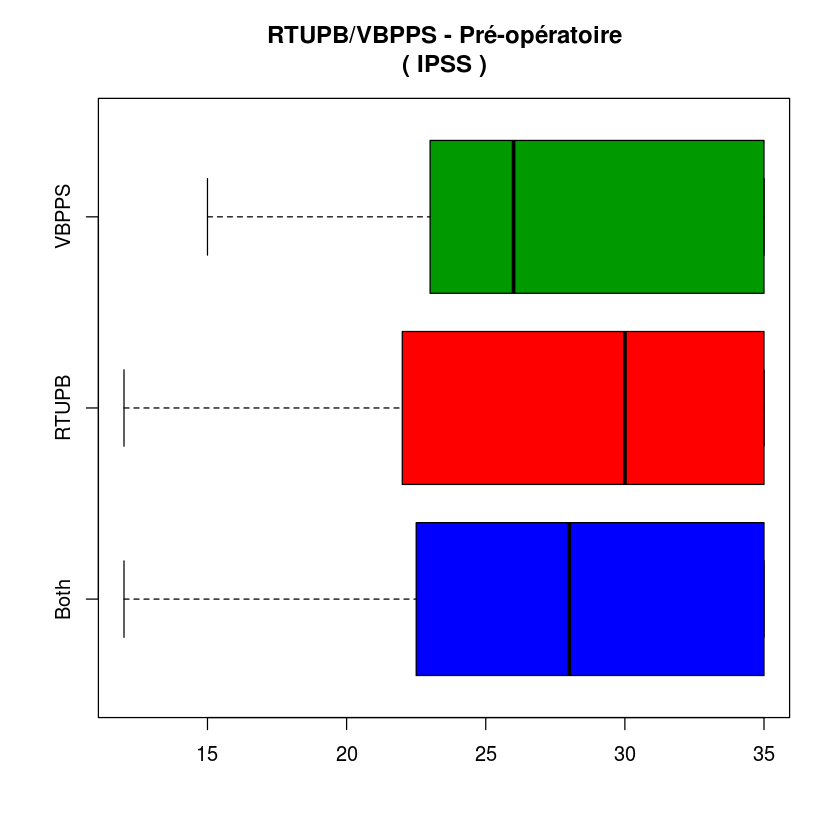

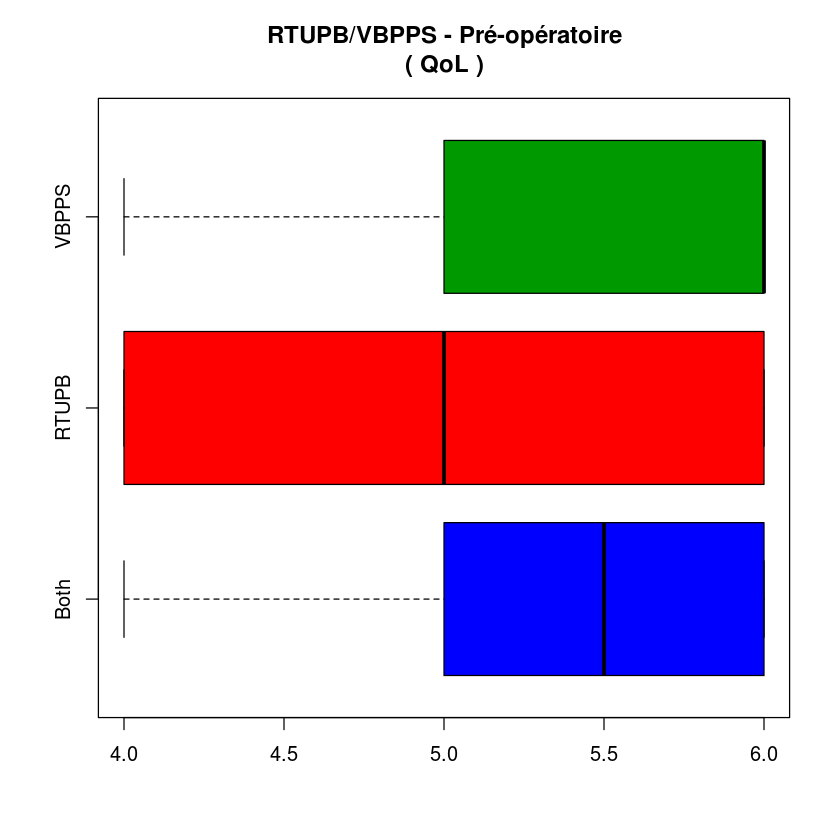

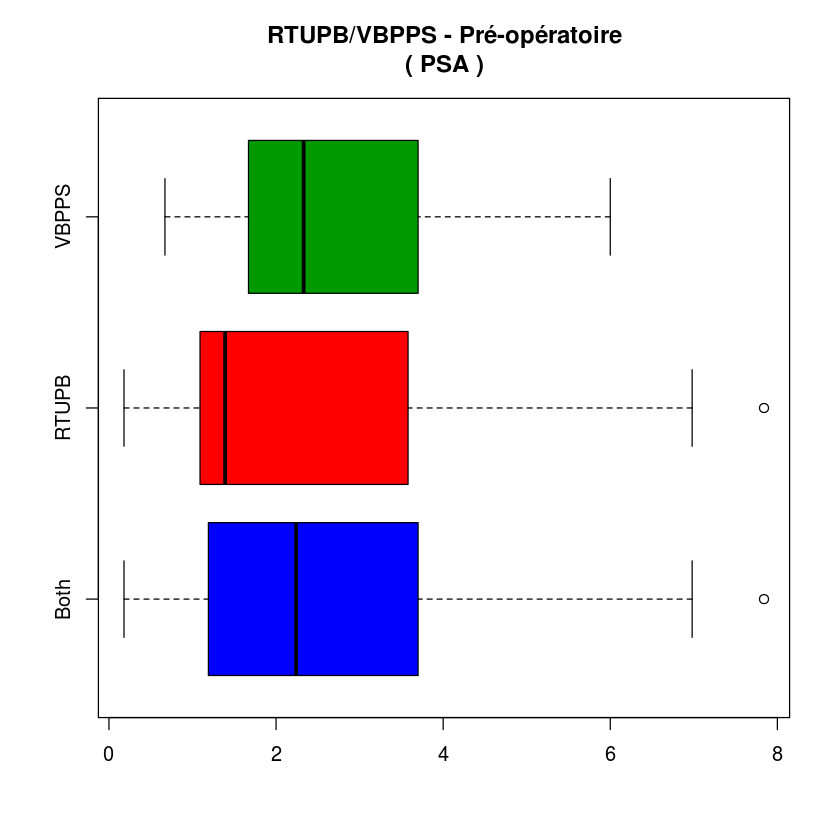

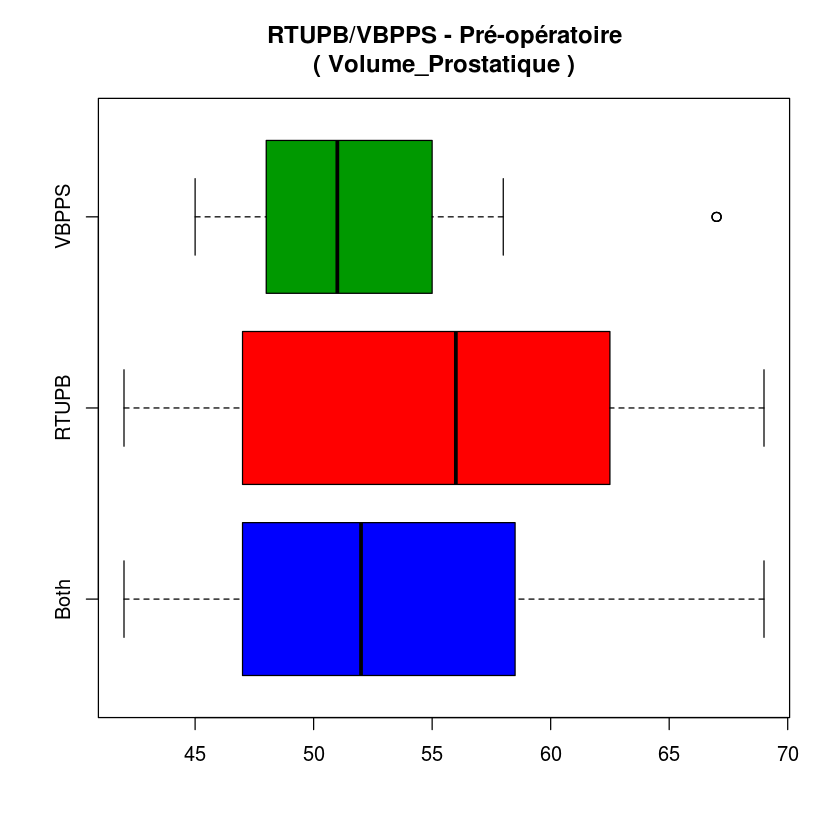

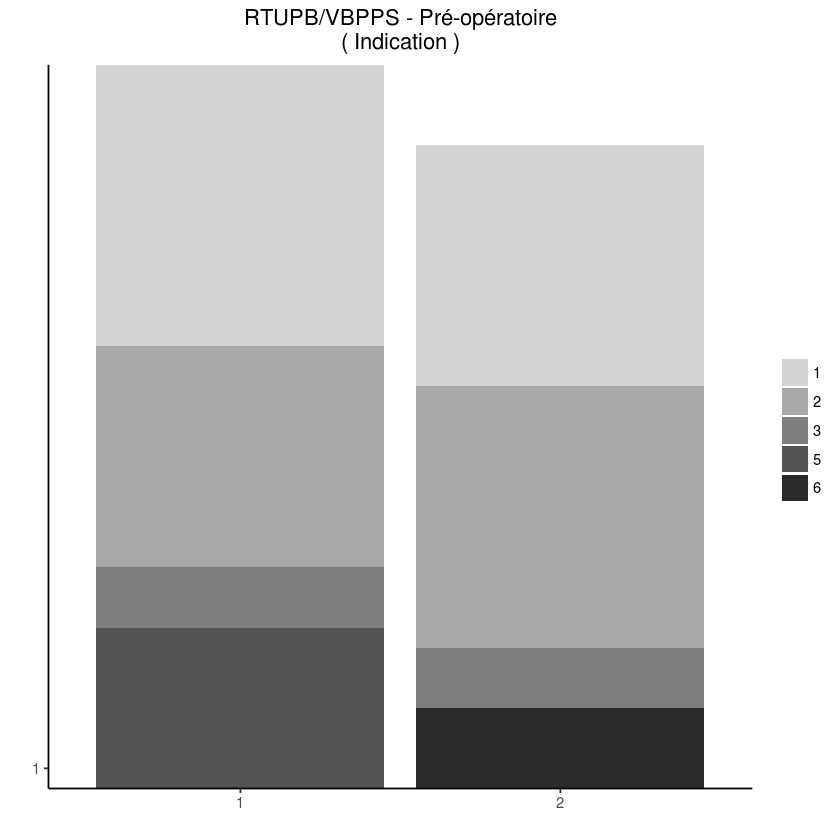

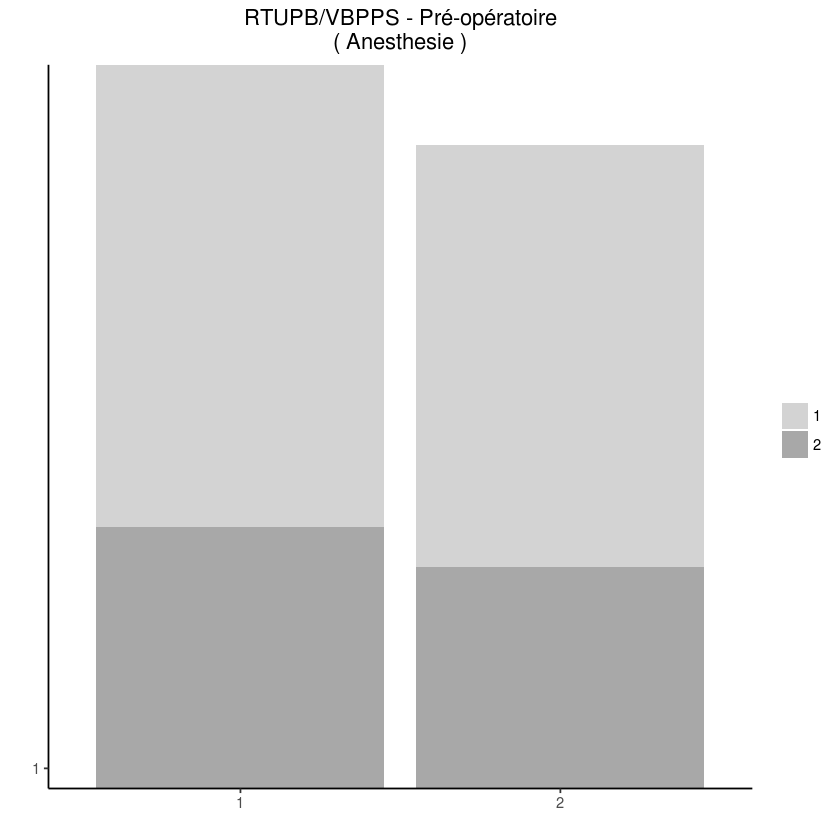

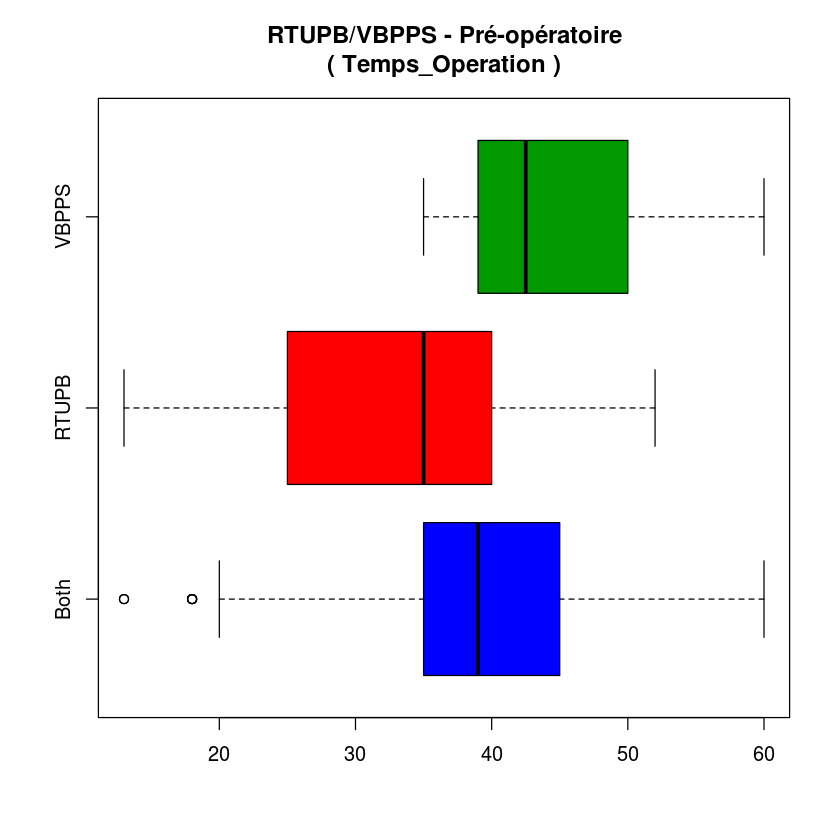

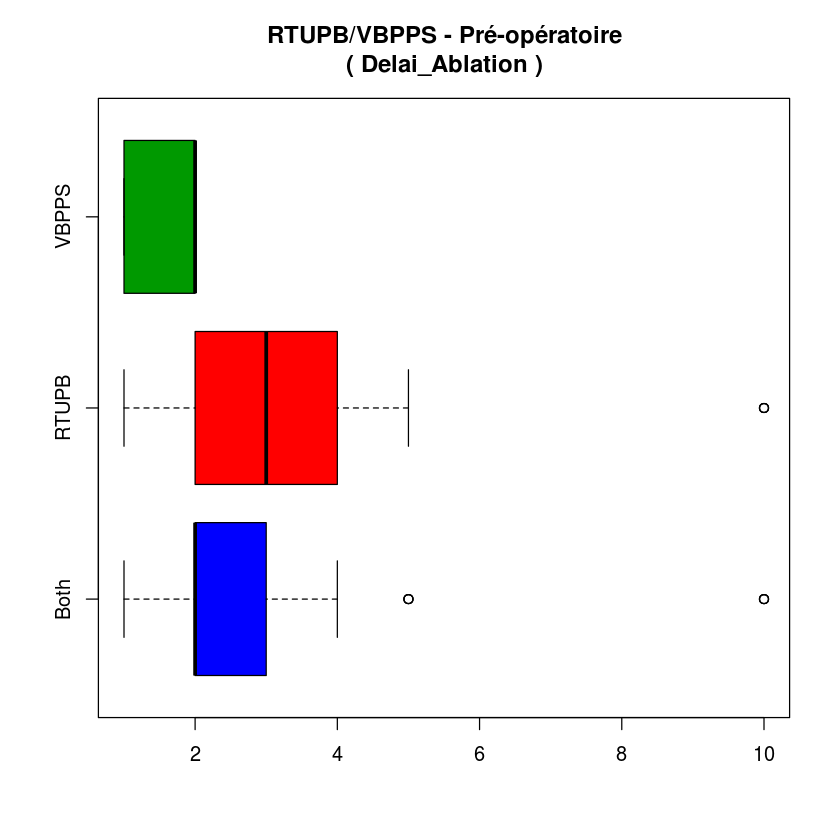

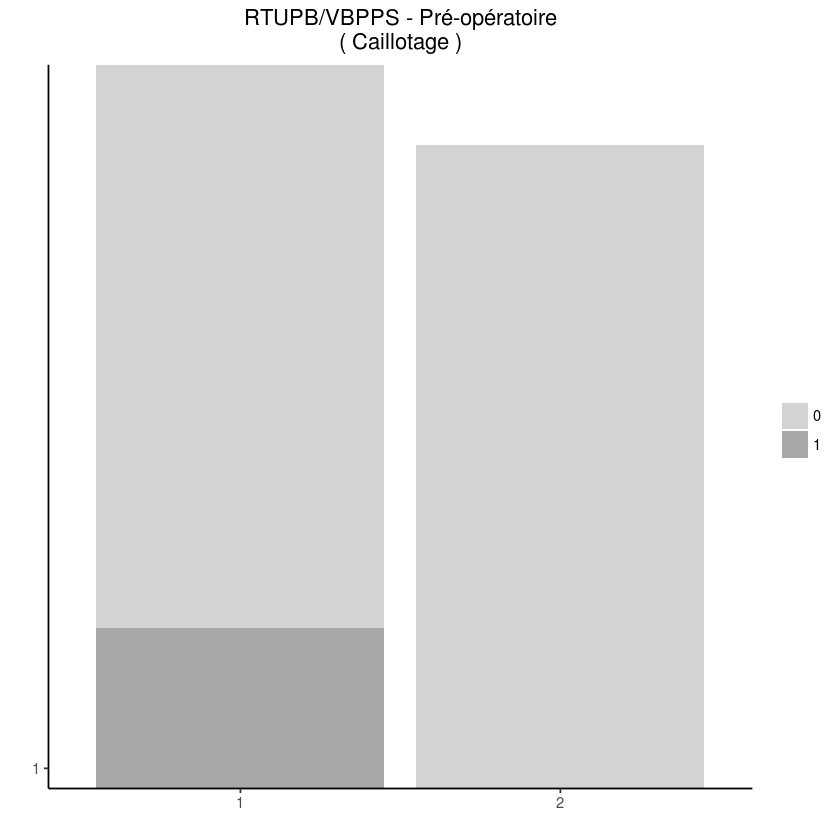

In [13]:
# Barplots des variables catégoriques
fill <- c("#d3d3d3", "#a8a8a8", "#7e7e7e", "#545454", "#2a2a2a")

for (i in 1:ncol(rtupb_vbpps_pre)) {
    # Boxplots des variables numériques
    if (is.numeric(rtupb_vbpps_pre[,i]))
        boxplot(rtupb_vbpps_pre[,i], rtupb_pre[,i], vbpps_pre[,i],
            names=c("Both","RTUPB","VBPPS"),horizontal=TRUE,main=paste("RTUPB/VBPPS - Pré-opératoire\n(", colnames(rtupb_vbpps_pre)[i],")"), col=c("blue","red","#009900"))
    else
        if (colnames(rtupb_vbpps_pre)[i] != "Technique"){
            # Stacked barplots des variables catégoriques
            p4 <- ggplot() + geom_bar(aes(y = factor(1), x = Technique, fill = rtupb_vbpps_pre[,i]), data = rtupb_vbpps_pre,
                stat="identity") +
                theme(legend.title = element_blank(), plot.title = element_text(hjust = 0.5)) +
                scale_fill_manual(values=fill) + labs(x="", y="") + ggtitle(paste("RTUPB/VBPPS - Pré-opératoire\n(",colnames(rtupb_vbpps_pre)[i],")"))
            print(p4)
    }
}

La durée de traitement médical est plus longue pour les patients qui ont reçu la technique VBPPS.
Le temps d'opération est plus long pour les patients qui ont reçu la technique VBPPS. Il est fort probable que cette technique demande effectivement plus de temps pour être exécutée.
Le délai d'ablation est moins long pour les patients VBPPS.
Aucun cas de caillotage n'est relevé pour les patients qui ont reçu le traitement VBPPS.

### c. Porteurs de sonde ou non

Il nous paraissait intéressant de montrer quelques chiffres en fonction des porteurs de sonde. En effet cette variable nous semble importante pour différencier 2 patiens.

Les porteurs de sonde sont plutôt les patients les plus âgés de notre population.

Il n'y a pas 1 choix de technique qui dépende du fait que le patient porte 1 sonde ou non.

Par contre, les porteurs de sonde ont l'IPSS maximum et ont aussi tous donné le même score presque maximal de "qualité de vie" (6 sur 1 échelle de 1 à 7) montrant la gêne que doit procurer la sonde.

Tous les patients équipés d'une sonde ont une valeur pour indication égale à 'Rétention vésicale aigue'. Ces patients sont donc dans l'incapacité d'uriner ce qui doit être une cause importante de déclenchement de l'opération.

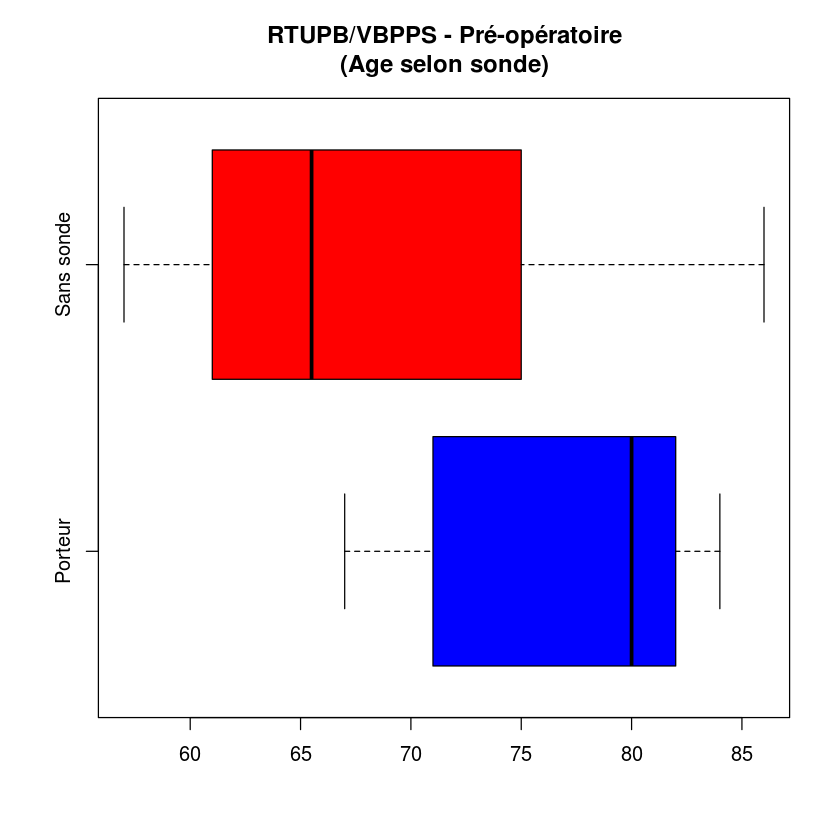

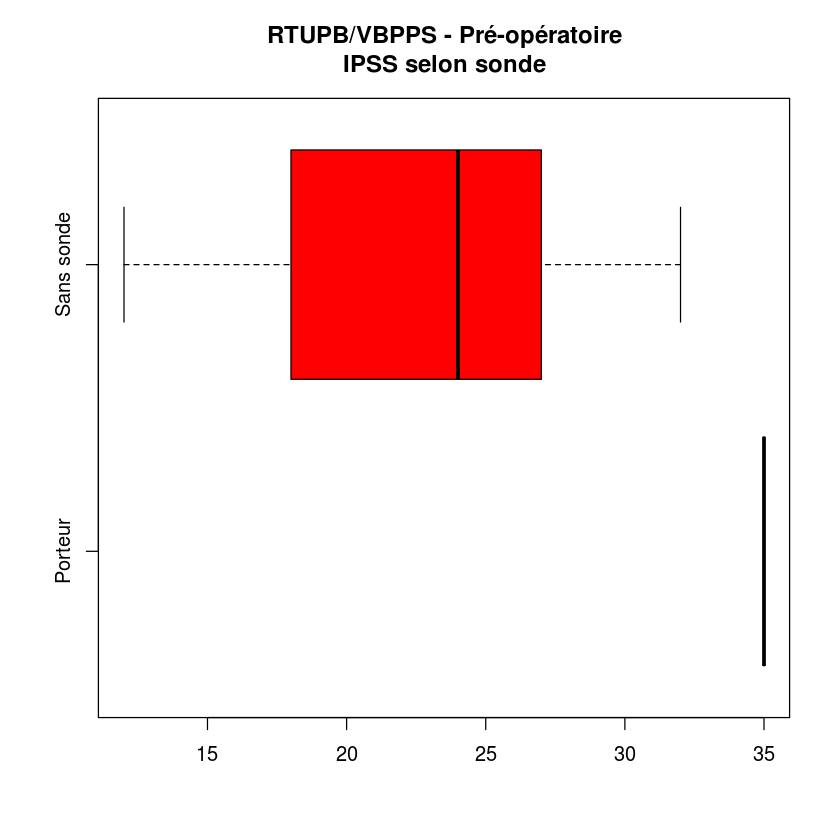

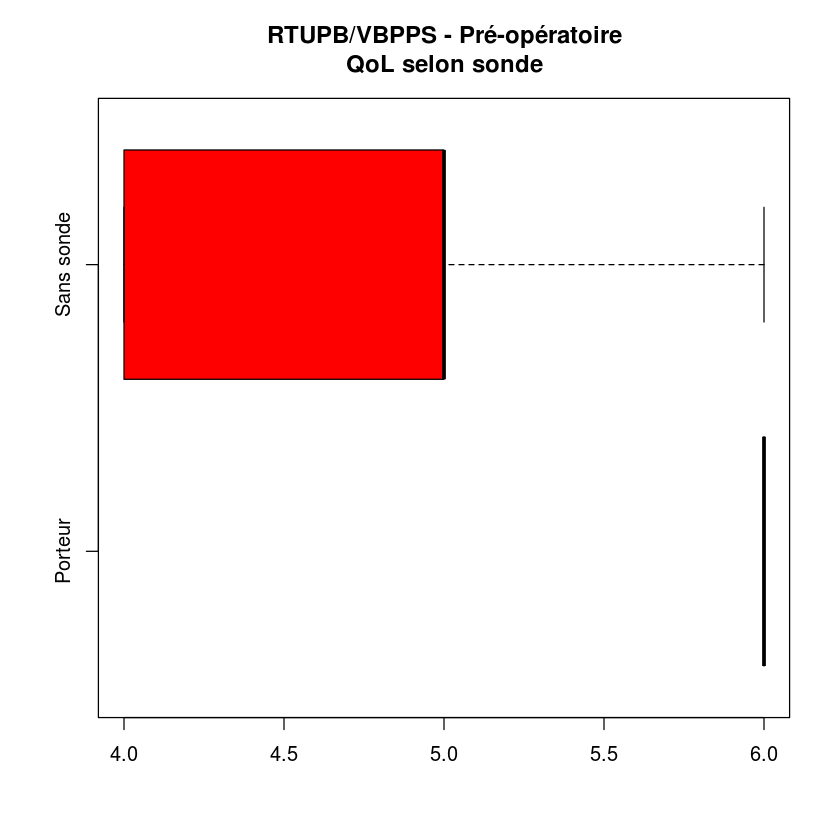

In [14]:
boxplot(rtupb_vbpps_pre[which(rtupb_vbpps_pre$Porteur_Sonde == 1),'Age'], rtupb_vbpps_pre[which(rtupb_vbpps_pre$Porteur_Sonde == 0),'Age'], names=c("Porteur","Sans sonde"),horizontal=TRUE,main="RTUPB/VBPPS - Pré-opératoire\n(Age selon sonde)", col=c("blue","red"))
boxplot(rtupb_vbpps_pre[which(rtupb_vbpps_pre$Porteur_Sonde == 1),'IPSS'], rtupb_vbpps_pre[which(rtupb_vbpps_pre$Porteur_Sonde == 0),'IPSS'], names=c("Porteur","Sans sonde"),horizontal=TRUE,main="RTUPB/VBPPS - Pré-opératoire\nIPSS selon sonde", col=c("blue","red"))
boxplot(rtupb_vbpps_pre[which(rtupb_vbpps_pre$Porteur_Sonde == 1),'QoL'], rtupb_vbpps_pre[which(rtupb_vbpps_pre$Porteur_Sonde == 0),'QoL'], names=c("Porteur","Sans sonde"),horizontal=TRUE,main="RTUPB/VBPPS - Pré-opératoire\nQoL selon sonde", col=c("blue","red"))

In [15]:
table(rtupb_vbpps$Porteur_Sonde, rtupb_vbpps$Technique,dnn = c('Sonde','Technique'))
table(rtupb_vbpps$Porteur_Sonde, rtupb_vbpps$Indication,dnn = c('Sonde','Indication'))

     Technique
Sonde  1  2
    0 22 20
    1 14 12

     Indication
Sonde  1  2  3  5  6
    0  0 24  6  8  4
    1 26  0  0  0  0

### 2.1.3 Corrélations

### a. Toute technique

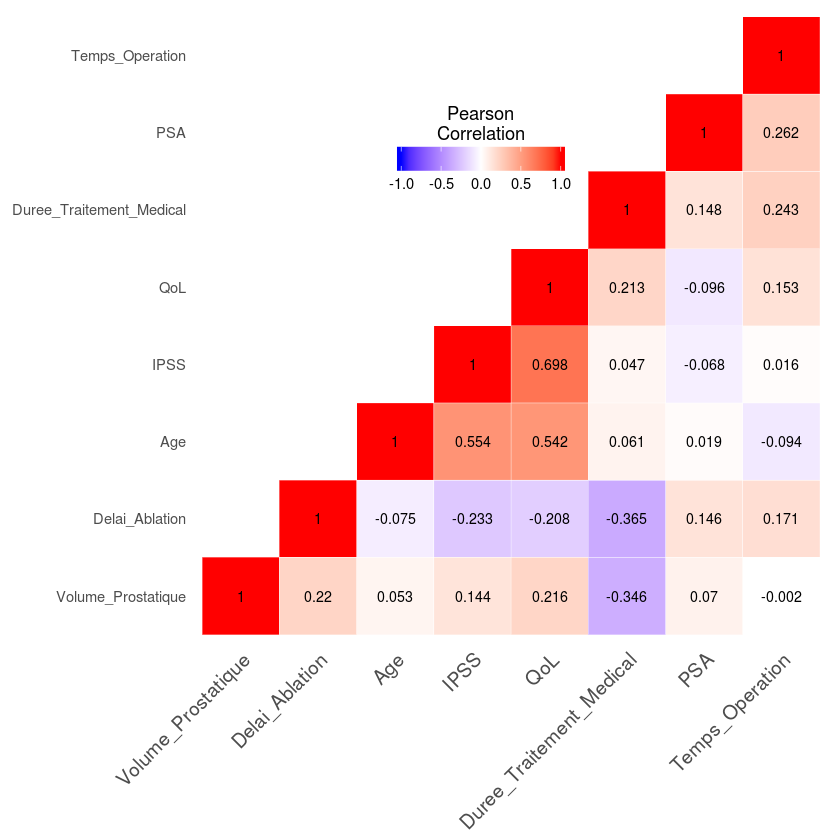

In [16]:
mat_cor = cor(rtupb_vbpps_pre_num, method = c("pearson"))
adenome_heatmap(mat_cor)

Nous notons une corrélation positive entre IPSS et QoL. Ainsi qu'entre la variable "Age" et les variables "QoL" et "IPSS". Plus le patient est âgé, plus le nombre de symptômes est important et plus son ressenti sur sa qualité de vie est mauvais.

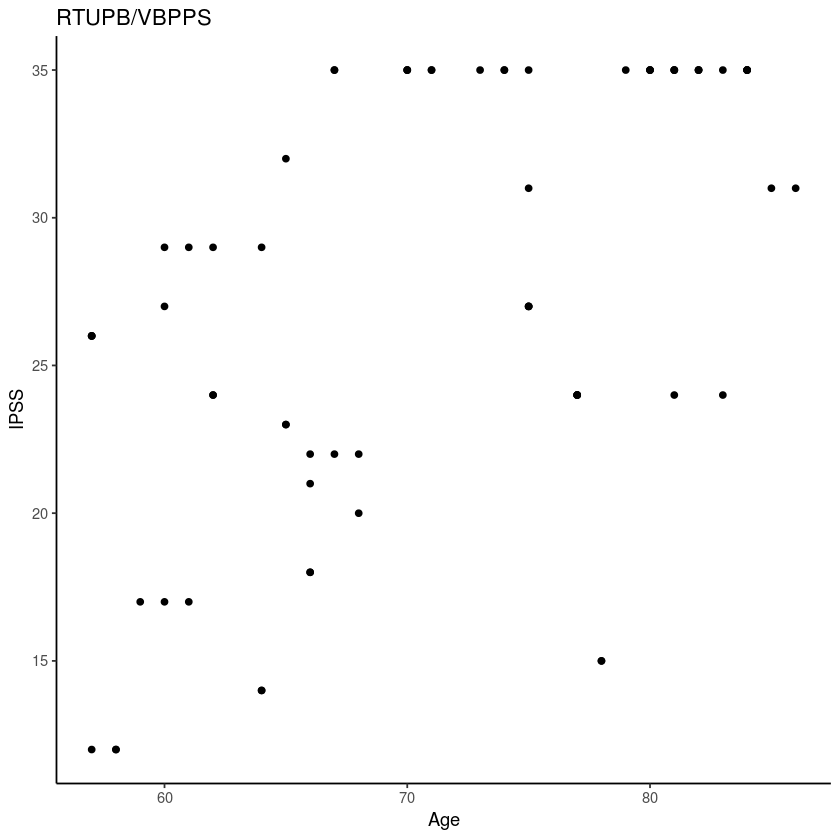

In [17]:
adenome_scatterplot(rtupb_vbpps_pre_num,rtupb_vbpps_pre_num$Age,rtupb_vbpps_pre_num$IPSS,"Age","IPSS")

Nous notons aussi une faible corrélation négative entre la "Durée du traitement médical" et les variables "Délai Ablation" et "Volume prostatique". Plus le traitement est long moins le délai d'ablation est important. Et moins la prostate est volumineuse. Cela pourrait vouloir dire que le traitement pré-opératoire agit sur la taille de la prostate avec une tendance à la faire diminuer.

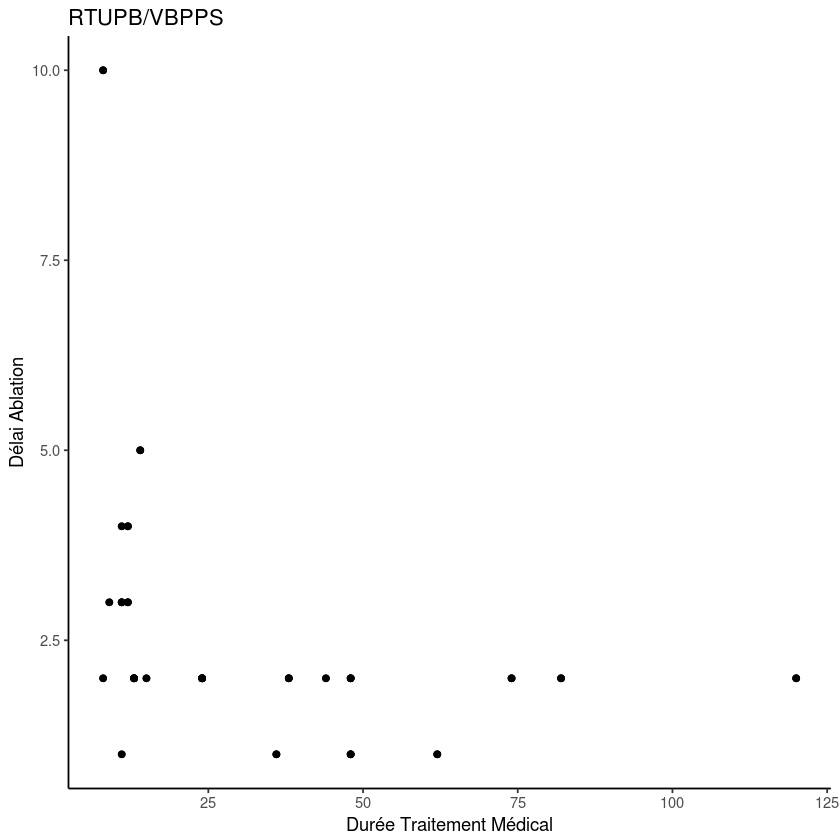

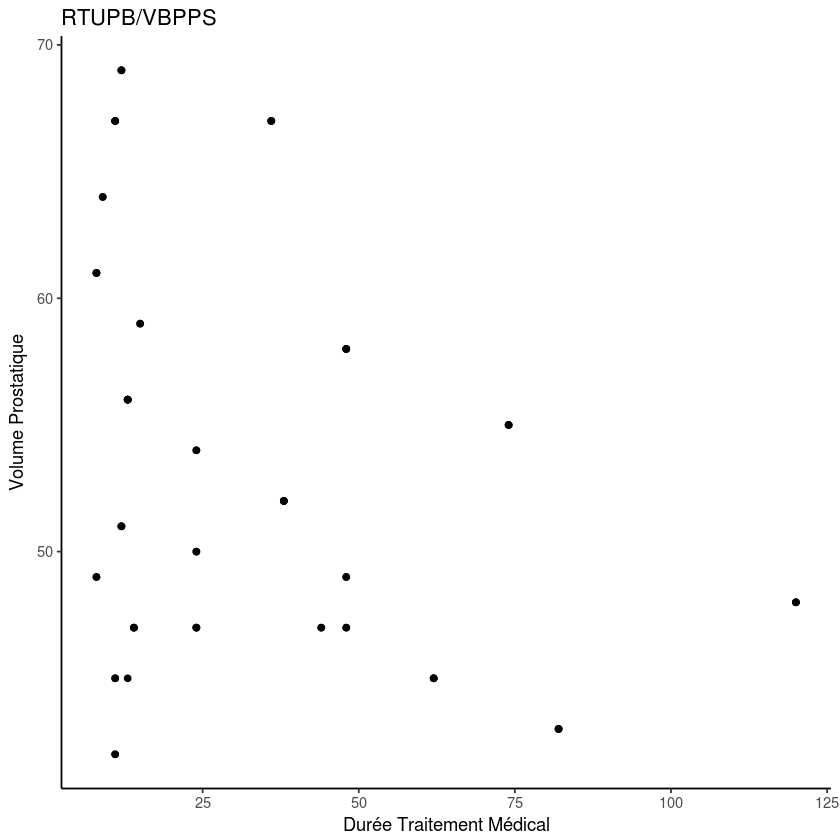

In [18]:
adenome_scatterplot(rtupb_vbpps_pre_num,rtupb_vbpps_pre_num$Duree_Traitement_Medical,rtupb_vbpps_pre$Delai_Ablation,"Durée Traitement Médical","Délai Ablation")
adenome_scatterplot(rtupb_vbpps_pre,rtupb_vbpps_pre$Duree_Traitement_Medical,rtupb_vbpps_pre$Volume_Prostatique,"Durée Traitement Médical","Volume Prostatique")

### b. Technique RTUPB

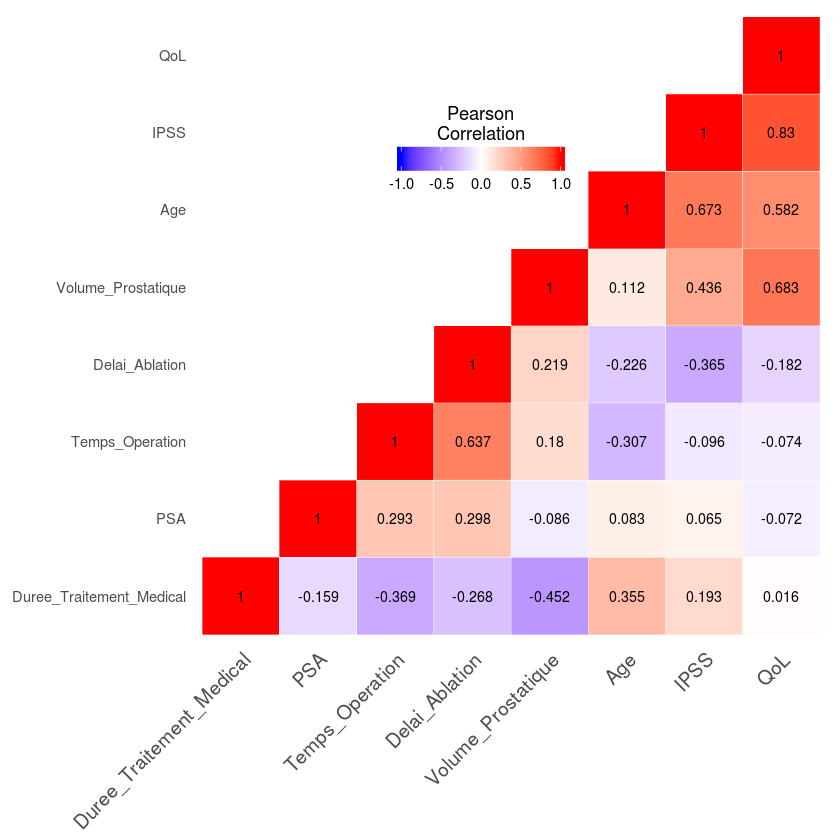

In [19]:
mat_cor = cor(rtupb_pre_num, method = c("pearson"))
adenome_heatmap(mat_cor)

En réduisant à la sous-population RTUPB, nous constatons les mêmes corrélations que pour la population globale. Ces corrélations positives sont légèrement plus fortes. Plus le patient est âgé, plus les symptômes sont importants et plus le ressenti de qualité de vie est médiocre.

Aussi nous retrouvons une corrélation positive entre le Temps d'opération et le délai d'ablation. Peut-être que l'ablation fait partie de l'opération et que plus cette étape est longue plus l'opération complète est longue.

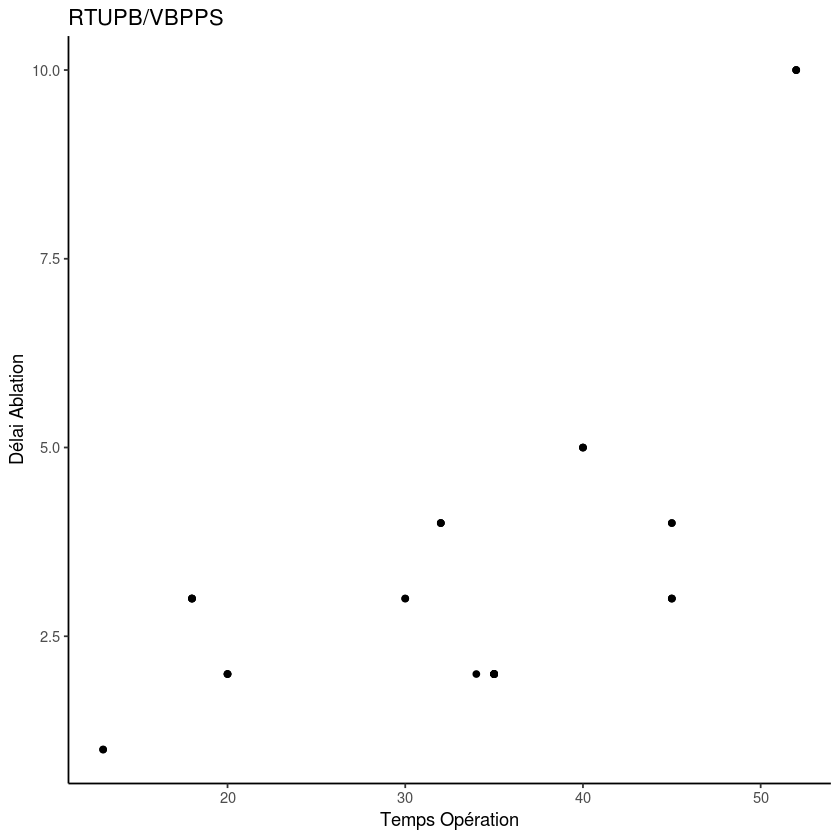

In [20]:
adenome_scatterplot(rtupb_pre_num,rtupb_pre_num$Temps_Operation,rtupb_pre_num$Delai_Ablation,"Temps Opération","Délai Ablation")

### c. Technique VBPPS

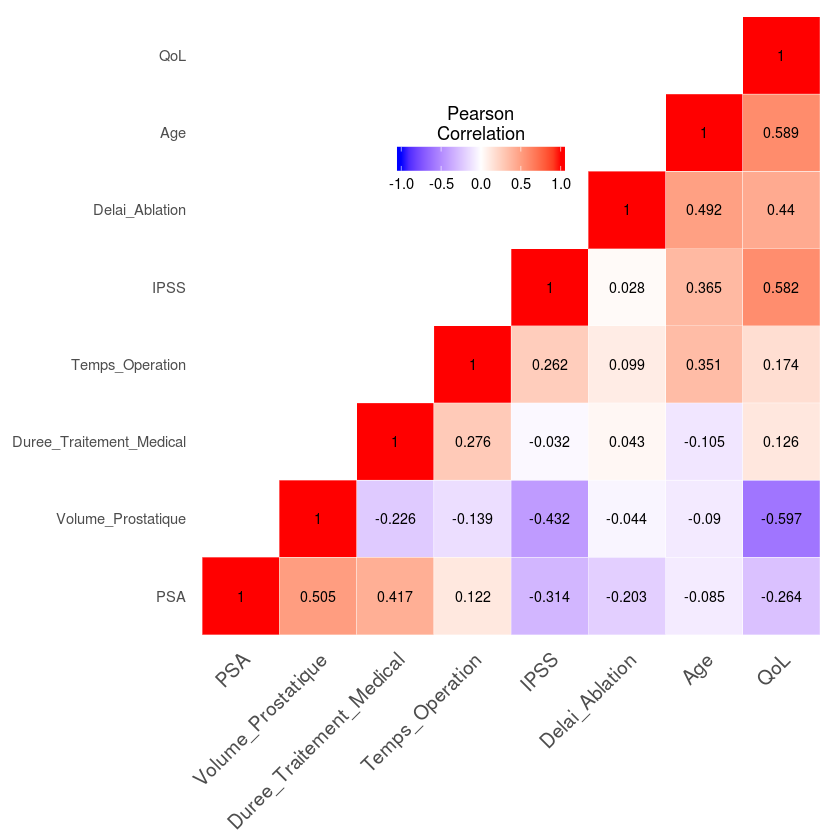

In [21]:
mat_cor = cor(vbpps_pre_num, method = c("pearson"))
adenome_heatmap(mat_cor)

En réduisant à la sous-population VBPPS, nous étudions les mêmes corrélations et hypothèses que celles décrites ci-dessus.

### 2.1.4 Analyse en composantes principales

In [22]:
pca <- stats::prcomp(x=rtupb_vbpps_pre_num)
summary(pca)

Importance of components:
                          PC1     PC2      PC3     PC4     PC5     PC6     PC7
Standard deviation     28.988 11.1160 10.24931 7.24312 5.31519 1.88519 1.55134
Proportion of Variance  0.727  0.1069  0.09089 0.04539 0.02444 0.00307 0.00208
Cumulative Proportion   0.727  0.8339  0.92481 0.97020 0.99464 0.99772 0.99980
                          PC8
Standard deviation     0.4825
Proportion of Variance 0.0002
Cumulative Proportion  1.0000

In [23]:
sum(100 * (pca$sdev^2)[1:2] / sum(pca$sdev^2))

[1] 83.39208

Ainsi les deux premières composantes à elles seules représentent 83% de l'information.

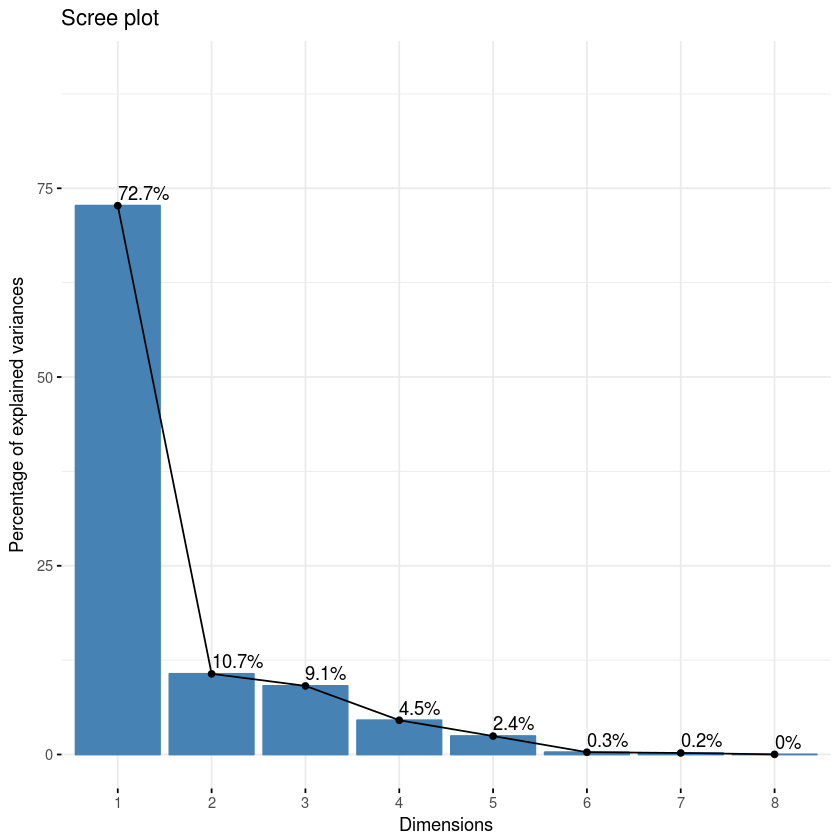

In [24]:
fviz_eig(pca, addlabels = TRUE, ylim = c(0, 90))

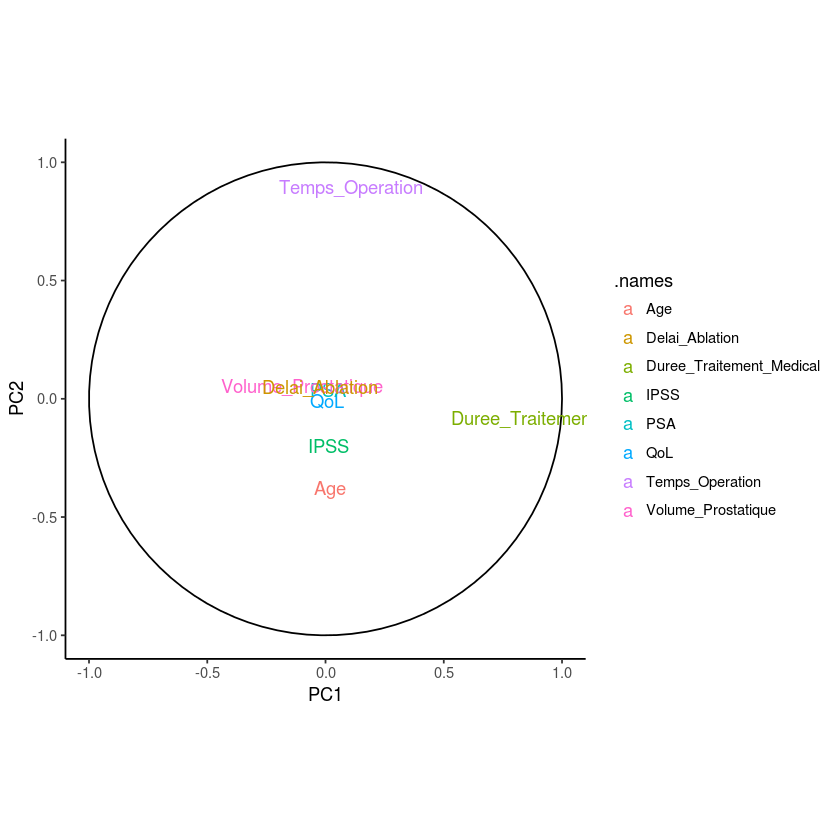

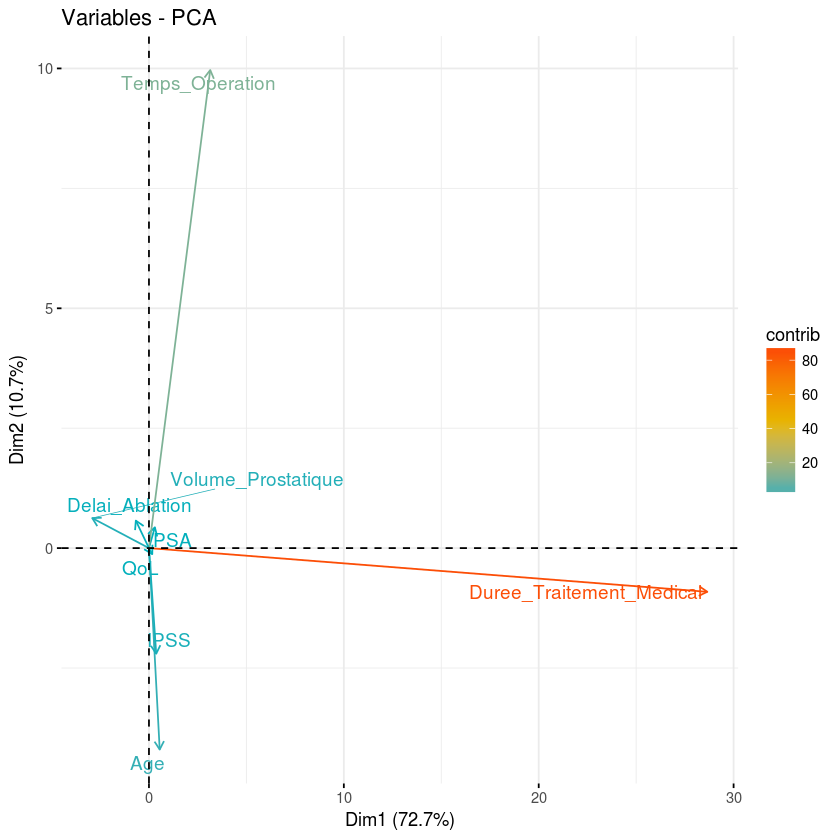

In [25]:
library("factoextra")
theta <- seq(0,2*pi,length.out = 100)
circle <- data.frame(x = cos(theta), y = sin(theta))
p <- ggplot(circle,aes(x,y)) + geom_path()
loadings <- data.frame(pca$rotation, 
.names = row.names(pca$rotation))
p + geom_text(data=loadings, 
mapping=aes(x = PC1, y = PC2, label = .names, colour = .names)) +
  coord_fixed(ratio=1) +
  labs(x = "PC1", y = "PC2")

fviz_pca_var(pca, col.var = "contrib",
             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
             repel = TRUE # Évite le chevauchement de texte
             )

En observant le graphe ci-dessus on peut déduire que la variable qui contribue le plus dans la PC1 est "Durée du traitement médical". 
Les variables qui contribuent le plus à la PC2 sont "Temps Opération" et, à l'opposé, "IPSS" et "Age".

On retrouve les corrélations positives entre les variables "IPSS", "Age" et "QoL".

## 2.2 Analyse descriptive - Post-opératoire

Nous avons décidé de ne pas montrer les distributions des variables post-opératoires prises séparemment car nos essais de boxplots et barcharts ne nous ont pas permis de dégager de faits intéressants en post-opératoire.

Par contre, afin de voir si nous pouvons déjà dégager plusieurs profils de guérison parmi tous les patients, nous avons eu l'idée de prendre plusieurs individus au hasard parmi tout le jeu de données et de faire un graphique de l'évolution de chacune des variables 'QMax', 'IPSS' et 'Qol' de ces individus en fonction du temps.

Nous avons également créé 2 faux individus qui vont représenter les techniques RTUPB et VBPPS séparemment. Chacun a une valeur pour chaque variable équivalente à la moyenne de cette variable pour leur sous-population respective (fonction de la technique). L'idée ici est de voir si la technique utilisée a 1 impact sur la durée de guérison.

Chaque individu est représenté par une courbe sur le même graphique. Un graphique par indice.

In [26]:
# on divise le dataset en 2 pour voir les techniques séparément
rtupb_post <- rtupb_vbpps_post[which(rtupb_vbpps_post$Technique == 1),]
vbpps_post <- rtupb_vbpps_post[which(rtupb_vbpps_post$Technique == 2),]

In [27]:
require(graphics)

# On choisit trois individus au hasard
individu = sample(1:nrow(rtupb_vbpps_post), 3)
i1=individu[1]
i2=individu[2]
i3=individu[3]

# On crée 2 individus moyens
imean_vbpps <- colMeans(subset(vbpps_post,select=-c(Technique)))
imean_rtupb <- colMeans(subset(rtupb_post,select=-c(Technique)))
# que l'on ajoute au dataset
mat <- rbind(rtupb_vbpps_post, c(1,t(imean_rtupb)), c(2,t(imean_vbpps)))

# On crée des séries temporels pour nos variable Q_max, IPSS et QoL
rtupb_vbpps_post_qmax=t(subset(mat,select=c(M1_Qmax,M3_Qmax,M6_Qmax,M9_Qmax,M12_Qmax,M15_Qmax,M18_Qmax)))
rtupb_vbpps_post_ipss=t(subset(mat,select=c(M1_IPSS,M3_IPSS,M6_IPSS,M9_IPSS,M12_IPSS,M15_IPSS,M18_IPSS)))
rtupb_vbpps_post_QoL=t(subset(mat,select=c(M1_QoL,M3_QoL,M6_QoL,M9_QoL,M12_QoL,M15_QoL,M18_QoL)))

rtupb_vbpps_post_series_qmax=ts(rtupb_vbpps_post_qmax, start=1/12,deltat=3/12)
rtupb_vbpps_post_series_ipss=ts(rtupb_vbpps_post_ipss, start=1/12,deltat=3/12)
rtupb_vbpps_post_series_QoL=ts(rtupb_vbpps_post_QoL, start=1/12,deltat=3/12)

### 2.2.1 Tendances de guérison ?

#### a. QMax

Le QMax est le débit maximal urinaire. Plus cette valeur est importante, plus la miction est de bonne qualité.
Pour preuve de guérison, on s'attend donc à voir remonter cette valeur. Au contraire, une valeur qui stagne ou qui régresse est un signe négatif pour la guérison.

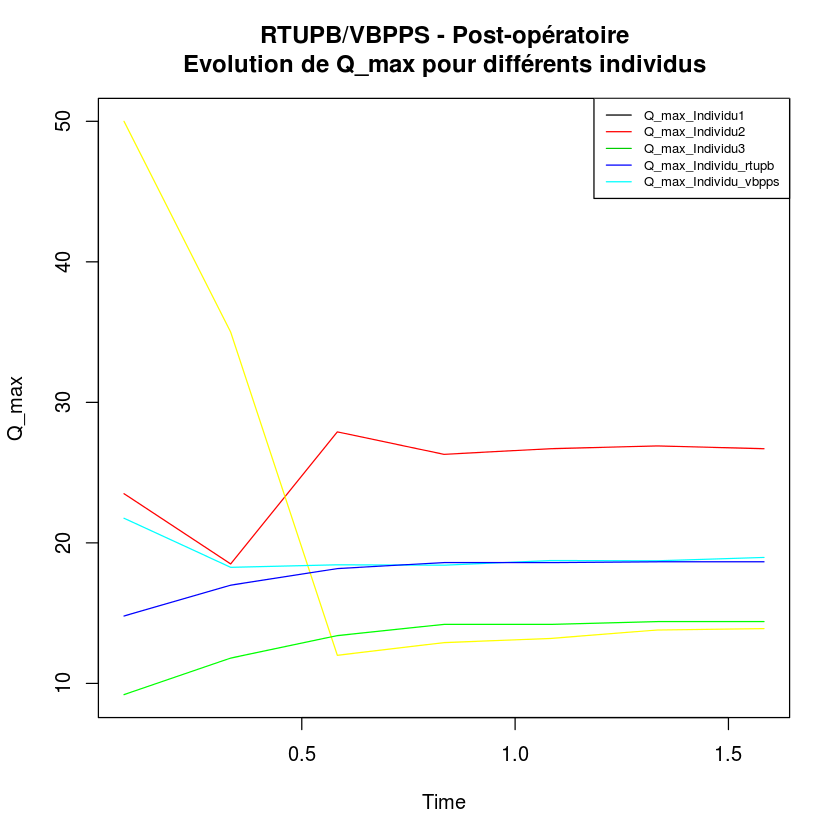

In [28]:
# On plot l'évolution de Q_max pour les 3 individus tirés au sort et les individus moyens pour chaque technique
Q_max_Individu1=rtupb_vbpps_post_series_qmax[,i1]
Q_max_Individu2=rtupb_vbpps_post_series_qmax[,i2]
Q_max_Individu3=rtupb_vbpps_post_series_qmax[,i3]
Q_max_Individu_rtupb=rtupb_vbpps_post_series_qmax[,70]
Q_max_Individu_vbpps=rtupb_vbpps_post_series_qmax[,69]
Q_max=cbind(Q_max_Individu1,Q_max_Individu2,Q_max_Individu3,Q_max_Individu_rtupb,Q_max_Individu_vbpps)

ts.plot(Q_max,gpars= list(col=rainbow(6)),ylab= "Q_max",main="RTUPB/VBPPS - Post-opératoire\nEvolution de Q_max pour différents individus")
legend("topright", colnames(Q_max), col=1:ncol(Q_max), lty=1, cex=.65)

On remarque que la technique opératoire utilisée n'a pas d'incidence forte sur la guérison. Toutefois on peut noter que la technique VBPPS semble converger plus vite et en moyenne elle procure une légère meilleure miction à la fin des 18 mois.

La courbe moyenne VBPPS commence par 1 régression. Cela est dû à 4 patients qui ont des valeurs de QMax au premier mois égales à presque 3 fois la valeur moyenne de la population globale.

Quel que soit le patient, il apparaît que la variable atteint un niveau qui ne change plus au bout du 9ème mois.

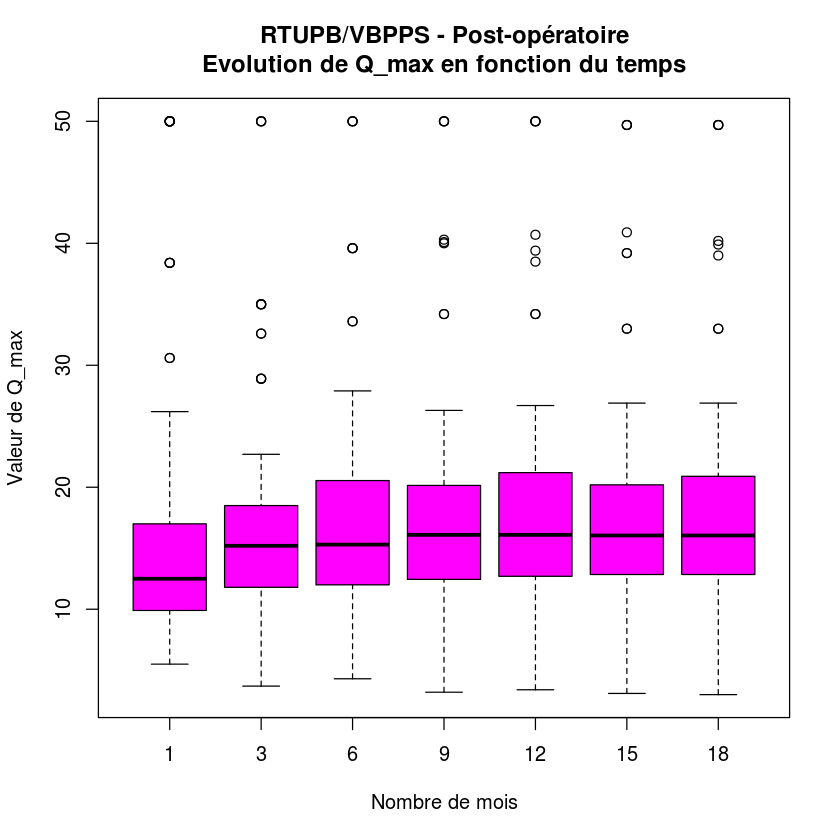

In [29]:
#On trace l'évolution de QMax en fonction du temps
Boxplot=matrix(NA,nrow=nrow(rtupb_vbpps_post),ncol=2)
for (i in 1:nrow(Boxplot)){
    Boxplot[i,2]=rtupb_vbpps_post$M1_Qmax[i]
    Boxplot[i,1]=1
}
Boxplot2=matrix(NA,nrow=nrow(rtupb_vbpps_post),ncol=2)
Qmax=subset(rtupb_vbpps_post,select=c(M3_Qmax,M6_Qmax,M9_Qmax,M12_Qmax,M15_Qmax,M18_Qmax))
for (i in 1:ncol(Qmax)){
for (k in 1:nrow(Boxplot2)){
    Boxplot2[k,2]=Qmax[k,i]
    Boxplot2[k,1]=i*3
}
Boxplot=rbind(Boxplot,Boxplot2)
}
boxplot(Boxplot[,2]~Boxplot[,1], main="RTUPB/VBPPS - Post-opératoire\nEvolution de Q_max en fonction du temps", col=6 ,xlab="Nombre de mois", ylab="Valeur de Q_max")

Ci-dessus la distribution des QMax selon le temps pour les 2 techniques. On note une stabilisation au bout du 9ème mois.

#### b. IPSS

L'IPSS est le "International Prostatic Symptome Score". C'est une représentation numérique de plusieurs scores en fonction des symptômes de l'adénome de la prostate.

Plus ce chiffre est elevé plus le patient est gené :

0 - 7 .......... Peu symptomatique

8 - 19 ......... Modérément symptomatique

20 - 35 ........ Symptomes sévères

Pour la guérison, on s'attend à une diminution de ce score.

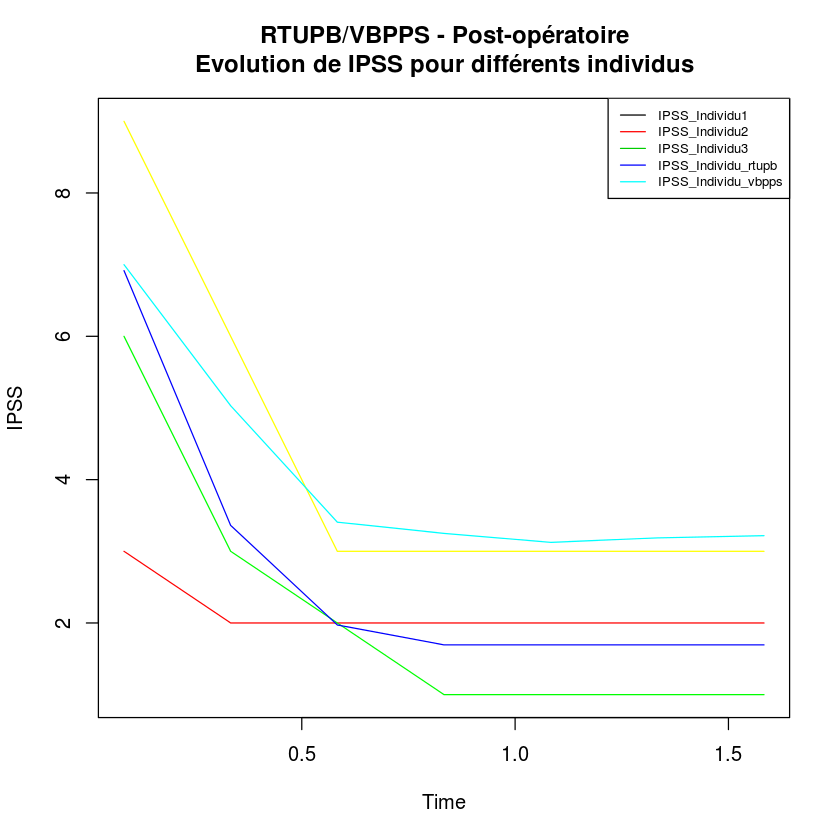

In [30]:
# On plot l'évolution de IPSS pour les 3 individus tirés au sort et les individus moyens pour chaque technique
IPSS_Individu1=rtupb_vbpps_post_series_ipss[,i1]
IPSS_Individu2=rtupb_vbpps_post_series_ipss[,i2]
IPSS_Individu3=rtupb_vbpps_post_series_ipss[,i3]
IPSS_Individu_rtupb=rtupb_vbpps_post_series_ipss[,70]
IPSS_Individu_vbpps=rtupb_vbpps_post_series_ipss[,69]
IPSS=cbind(IPSS_Individu1,IPSS_Individu2,IPSS_Individu3,IPSS_Individu_rtupb,IPSS_Individu_vbpps)

ts.plot(IPSS,gpars= list(col=rainbow(6)),ylab= "IPSS",main="RTUPB/VBPPS - Post-opératoire\nEvolution de IPSS pour différents individus")
legend("topright", colnames(IPSS), col=1:ncol(IPSS), lty=1, cex=.65)

L'IPSS semble diminuer plus rapidement pour la technique RTUPB jusqu'à atteindre un plancher plus bas que pour la technique VBPPS. L'indice est rapidement dans la zone "non symptomatique" (en dessous de 8 donc) quel que soit le patient ou la technique. Il est d'ailleurs très en deça de l'IPSS pré-opératoire, preuve que l'operation, quelle que soit la technique, élimine la plupart des symptômes. Ci-dessous les moyennes IPSS :

In [31]:
cat ("Moyenne pré-opératoire - toute population / RTUPB / VBPPS : ...........", mean(rtupb_vbpps$IPSS), mean(rtupb_pre$IPSS), mean(vbpps_pre$IPSS),"\n")
cat ("Moyenne post-opératoire 1er mois - toute population /RTUPB / VBPPS : ..", mean(rtupb_vbpps$M1_IPSS), mean(rtupb_post$M1_IPSS), mean(vbpps_post$M1_IPSS),"\n")

Moyenne pré-opératoire - toute population / RTUPB / VBPPS : ........... 27.39706 27.58333 27.1875 
Moyenne post-opératoire 1er mois - toute population /RTUPB / VBPPS : .. 6.955882 6.916667 7 


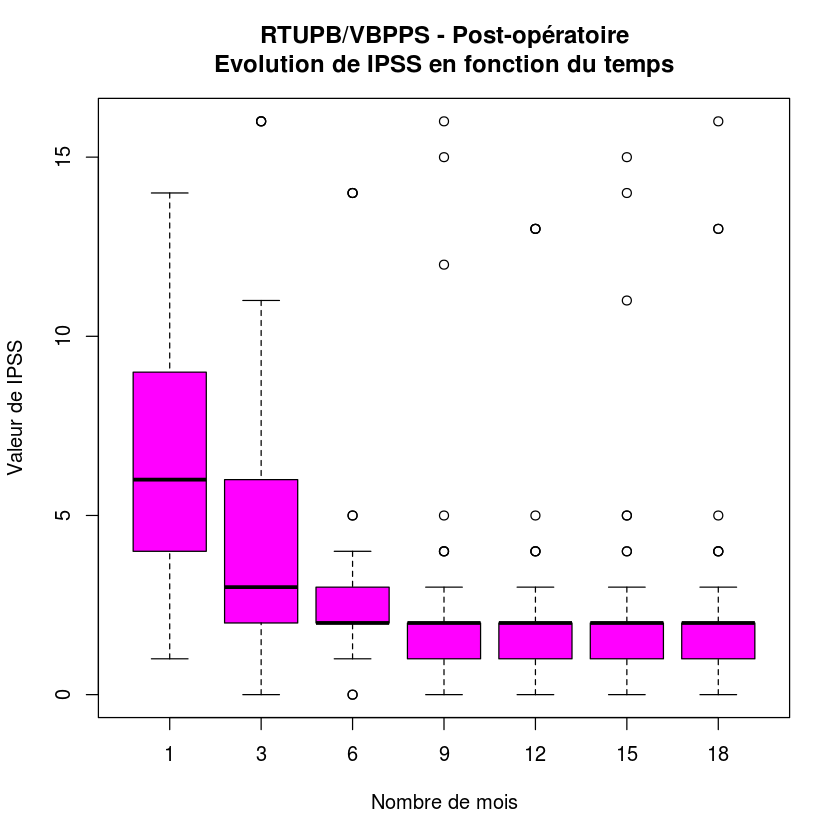

In [32]:
#On trace l'évolution d'IPSS en fonction du temps
Boxplot=matrix(NA,nrow=nrow(rtupb_vbpps_post),ncol=2)
for (i in 1:nrow(Boxplot)){
    Boxplot[i,2]=rtupb_vbpps_post$M1_IPSS[i]
    Boxplot[i,1]=1
}
Boxplot2=matrix(NA,nrow=nrow(rtupb_vbpps_post),ncol=2)
IPSS=subset(rtupb_vbpps_post,select=c(M3_IPSS,M6_IPSS,M9_IPSS,M12_IPSS,M15_IPSS,M18_IPSS))
for (i in 1:ncol(IPSS)){
for (k in 1:nrow(Boxplot2)){
    Boxplot2[k,2]=IPSS[k,i]
    Boxplot2[k,1]=i*3
}
Boxplot=rbind(Boxplot,Boxplot2)
}
boxplot(Boxplot[,2]~Boxplot[,1], main="RTUPB/VBPPS - Post-opératoire\nEvolution de IPSS en fonction du temps", col=6 ,xlab="Nombre de mois", ylab="Valeur de IPSS")

Ci-dessus la distribution des IPSS selon le temps pour les 2 techniques. On note une stabilisation au bout du 9ème mois.

#### c. QoL

L'indice 'QoL' représente le score donné par le patient pour sa qualité de vie. Plus ce score est élevé plus le patient est insatisfait. 
Ce score va de 1 à 7.

Pour la guérison, on s'attend à voir ce score diminuer.

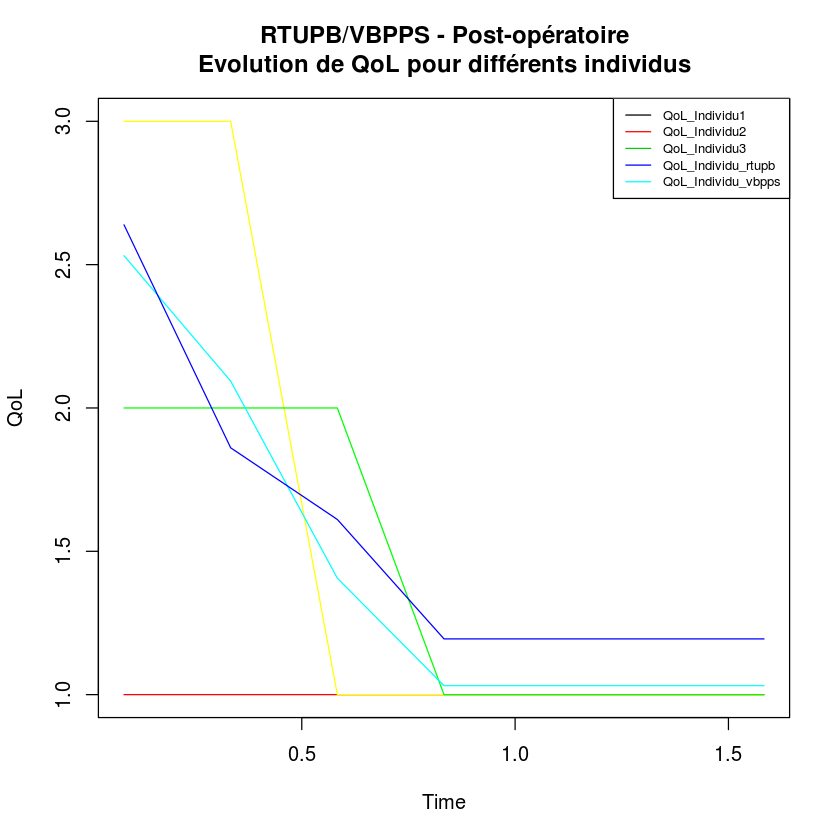

In [33]:
# On plot l'évolution de QoL pour les 3 individus tirés au sort et les individus moyens pour chaque technique
QoL_Individu1=rtupb_vbpps_post_series_QoL[,i1]
QoL_Individu2=rtupb_vbpps_post_series_QoL[,i2]
QoL_Individu3=rtupb_vbpps_post_series_QoL[,i3]
QoL_Individu_rtupb=rtupb_vbpps_post_series_QoL[,70]
QoL_Individu_vbpps=rtupb_vbpps_post_series_QoL[,69]
QoL=cbind(QoL_Individu1,QoL_Individu2,QoL_Individu3,QoL_Individu_rtupb,QoL_Individu_vbpps)

ts.plot(QoL,gpars= list(col=rainbow(6)),ylab= "QoL",main="RTUPB/VBPPS - Post-opératoire\nEvolution de QoL pour différents individus")
legend("topright", colnames(QoL), col=1:ncol(QoL), lty=1, cex=.65)

Pour le QoL, nous ne notons pas de différence significative entre les 2 techniques. L'évolution est similaire avec une chute importante entre le 1er et le 9ème mois où l'indice atteint un seuil plancher. En moyenne les patients RTUPB restent légèrement moins satisfaits que les patients VBPPS.

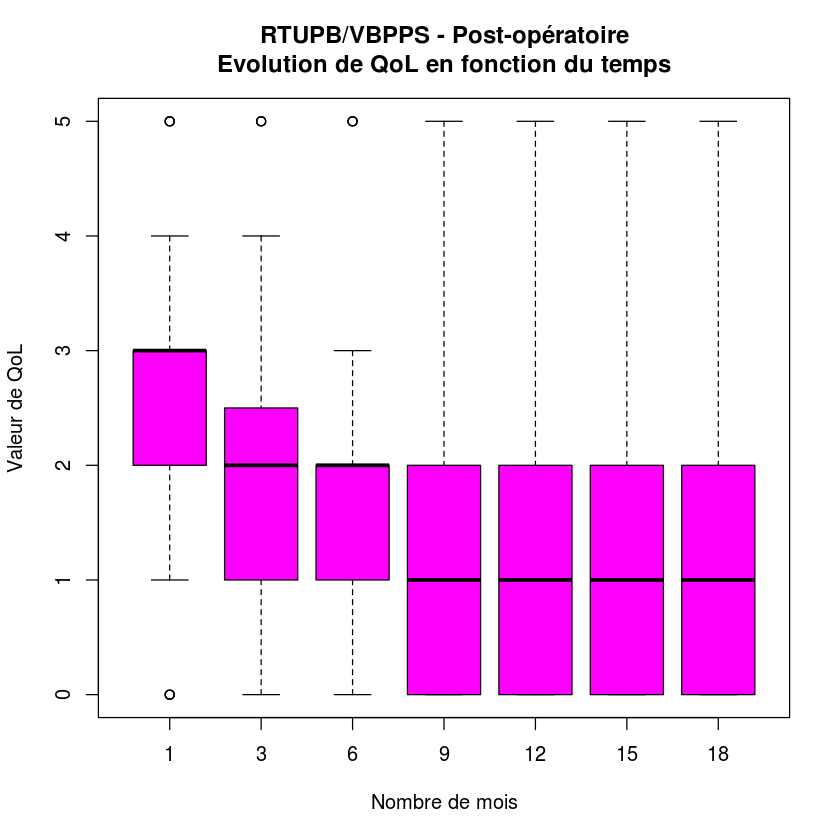

In [34]:
#On trace l'évolution de QoL en fonction du temps
Boxplot=matrix(NA,nrow=nrow(rtupb_vbpps_post),ncol=2)
for (i in 1:nrow(Boxplot)){
    Boxplot[i,2]=rtupb_vbpps_post$M1_QoL[i]
    Boxplot[i,1]=1
}
Boxplot2=matrix(NA,nrow=nrow(rtupb_vbpps_post),ncol=2)
QoL=subset(rtupb_vbpps_post,select=c(M3_QoL,M6_QoL,M9_QoL,M12_QoL,M15_QoL,M18_QoL))
for (i in 1:ncol(QoL)){
for (k in 1:nrow(Boxplot2)){
    Boxplot2[k,2]=QoL[k,i]
    Boxplot2[k,1]=i*3
}
Boxplot=rbind(Boxplot,Boxplot2)
}
boxplot(Boxplot[,2]~Boxplot[,1], main="RTUPB/VBPPS - Post-opératoire\nEvolution de QoL en fonction du temps", col=6 ,xlab="Nombre de mois", ylab="Valeur de QoL")

Ci-dessus la distribution des QoL selon le temps pour les 2 techniques. On note une stabilisation au bout du 9ème mois.

### 2.2.2 Corrélations

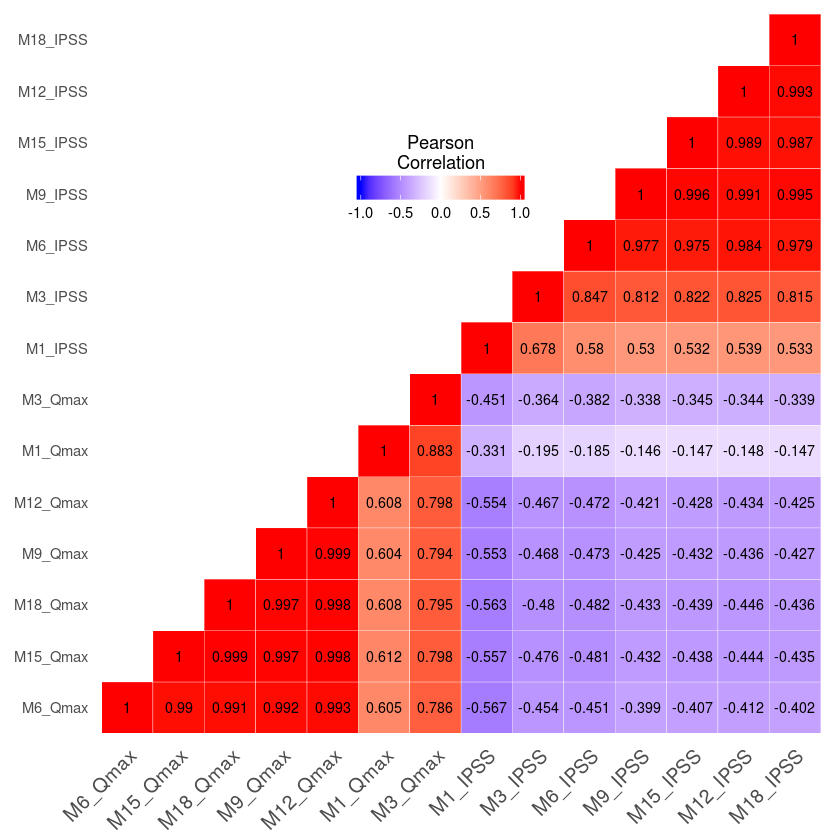

In [35]:
mat <- subset(rtupb_vbpps_post, select = c(M1_Qmax,M1_IPSS,M3_Qmax,M3_IPSS,M6_Qmax,M6_IPSS,M9_Qmax,M9_IPSS,M12_Qmax,M12_IPSS,M15_Qmax,M15_IPSS,M18_Qmax,M18_IPSS))
mat_cor = cor(mat, method = c("pearson"))
adenome_heatmap(mat_cor)

Pour rappel, nous n'avions pas la variable "Qmax" en pré-opératoire. Nous n'avions donc pas pu analyser les corrélations avec les autres variables. Ici, en post-opératoire, nous pouvons étudier ces corrélations.

En pré-opératoire, nous avions noté des corrélations positives entre "IPSS" et "QoL" : plus le score IPSS est haut, plus le ressenti du patient en qualité de vie est médiocre. 
Sur ce principe et pour une meilleure visibilité, nous avons choisi de n'étudier les corrélations que pour les 2 variables "IPSS" et "Qmax".

Ces indices étant des scores liés par une notion de temps et censés évoluer dans le même sens en fonction du temps, les corrélations semblent évidentes entre les mêmes indices à différents moments. Plus le temps passe et plus les indices sont corrélés entre eux. C'est un signe de convergence et d'orientation dans le sens de la guérison.

Les variables Qmax sont corrélées négativement avec les variables "IPSS" et "QoL" : plus les symptômes vont diminuer et la vie du patient s'améliorer, plus la miction deviendra bonne. Une miction qui s'améliore est un signe évident de guérison du patient.

### 2.2.3 Conclusion analyse exploratoire post-opération

De cette analyse exploratoire post-opération, on peut en conclure plusieurs choses :
- l'opération est bénéfique pour le patient qui peut espérer fortement une guérison
- une grande partie des patients aura guerri après le 9ème mois
- il existe plusieurs profils qui auront une guérison plus ou moins rapide
- la technique opératoire ne semble pas avoir d'incidence significative sur la durée de guérison

In [36]:
# On supprime les 2 individus moyens de nos time series qui seront utilisées plus tard
rtupb_vbpps_post_series_qmax <- subset(rtupb_vbpps_post_series_qmax, select = -c(69,70))
rtupb_vbpps_post_series_ipss <- subset(rtupb_vbpps_post_series_ipss, select = -c(69,70))
rtupb_vbpps_post_series_QoL <- subset(rtupb_vbpps_post_series_QoL, select = -c(69,70))

# 3. Clustering des données RTUPB-VBPPS

## 3.1 Extraction des profils types de patients à partir des données pré-opératoires

### 3.1.1 CAH

La Classification Ascendante Hiérarchique est une bonne première approche pour aider à la détermination du nombre de classes idéal. Notamment par le biais du dendrogramme qui permet de visualiser des intuitions.

Nous prenons bien soin de retirer la variable "Technique" de notre recherche de clustering car nous allons chercher à étudier cette variable plus tard dans l'analyse. Il ne serait pas correct de l'utiliser pour calculer les dissimilarités.

Le calcul de la matrice des dissimilarités se fera à l'aide de la fonction R 'Daisy' et de la distance de Gower. Cette distance permet de calculer des similarités et dissimilarités sur des matrices hétérogènes comme c'est le cas dans notre jeu de données. En effet, nous avons des variables quantitatives et des variables qualitatives.

In [37]:
require(cluster)
library(fpc)

# On ne prend pas en compte la variable Technique dans le clustering
df_pour_clustering <- subset(rtupb_vbpps_pre,select=-c(Technique))

# On crée notre matrice de dissimilarité utilisant daisy car matrice hétérogène
gower_dist = daisy(df_pour_clustering, metric = "gower")

summary(gower_dist)
gower_mat <- as.matrix(gower_dist)

2278 dissimilarities, summarized :
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.2784  0.3832  0.3716  0.4639  0.7351 
Metric :  mixed ;  Types = I, N, I, N, I, I, I, I, N, N, I, I, N 
Number of objects : 68

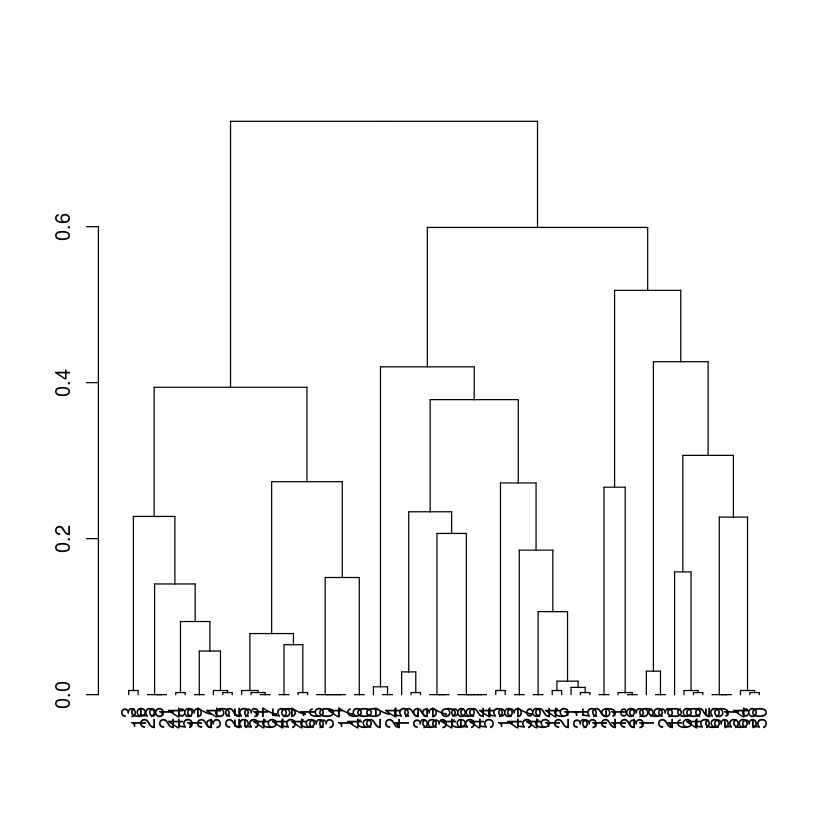

In [38]:
## Tracé du dendrogramme
cah_pre_op <- hclust(gower_dist)

plot(as.dendrogram(cah_pre_op))

En regardant le dendrogramme, nous pouvons évaluer un nombre de classes de 3 ou 4.

### 3.1.2 PAM

Effectuons maintenant le test de silhouette avec l'algorithme PAM (Partitioning Around Medoids) pour confirmer ou infirmer notre intuition déduite de la CAH.

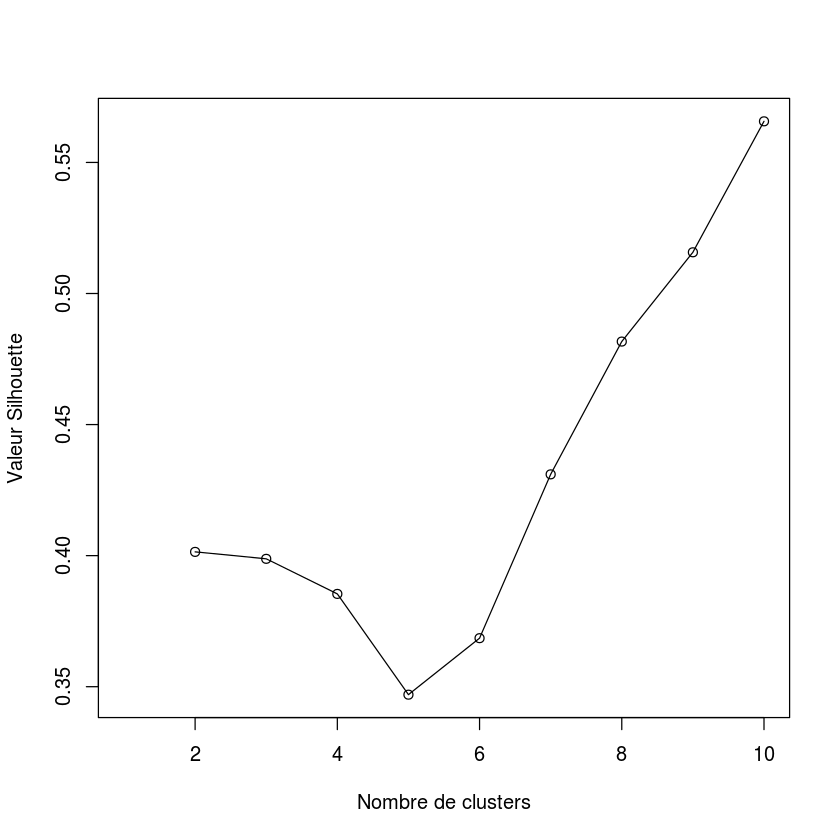

In [39]:
# Calculate silhouette width for many k using PAM
sil_width <- c(NA)

for(i in 2:10){
  pam_test <- pam(gower_dist, diss = TRUE, k = i)
  sil_width[i] <- pam_test$silinfo$avg.width
}

# Plot sihouette width (higher is better)

plot(1:10, sil_width, xlab = "Nombre de clusters", ylab = "Valeur Silhouette")
lines(1:10, sil_width)

L'analyse des silhouettes n'est pas concluante et ne vient pas confirmer notre intuition apportée avec l'aide du dendrogramme. En effet, il faudrait un nombre très important de classes pour avoir des valeurs silhouette proches de 1. Pour être au delà de 0.7, valeur communément admise comme silhouette moyenne acceptable, il faut avoir plus de 10 classes. Par la suite, il sera très difficile d'interpréter un si grand nombre de classes.

La valeur silhouette n'est qu'une clé pour aider au choix du nombre de classes. 
En général, il n'est pas intéressant, voire contre-productif, d'avoir 1 nombre de clusters supérieur à 10% de la population. Dans notre cas, cela signifie que nous ne devrions pas aller au-delà de 6 classes.

Jusqu'à 6 classes, les valeurs silhouettes les plus importantes sont pour 2 et 3 classes. En recoupant avec l'intuition apportée par le dendrogramme, nous pensons que 3 classes est un bon choix.

De plus, pour 3 classes, nous avons une répartition plutôt homogène des individus.

In [40]:
k.patient.optimal = 3

pam.patient <- pam(gower_dist, diss = TRUE, k = k.patient.optimal, metric = "gower")
pam.patient$clusinfo

size,max_diss,av_diss,diameter,separation
24,0.3380102,0.1985036,0.4203080,0.2659938
26,0.2702409,0.1395546,0.3941044,0.2741430
18,0.3195286,0.2347373,0.5184103,0.2659938


Nous faisons donc le choix de 3 profils de patients.

Ci-dessous, une visualisation en 2D des 3 clusters selon les 2 premières composantes principales.

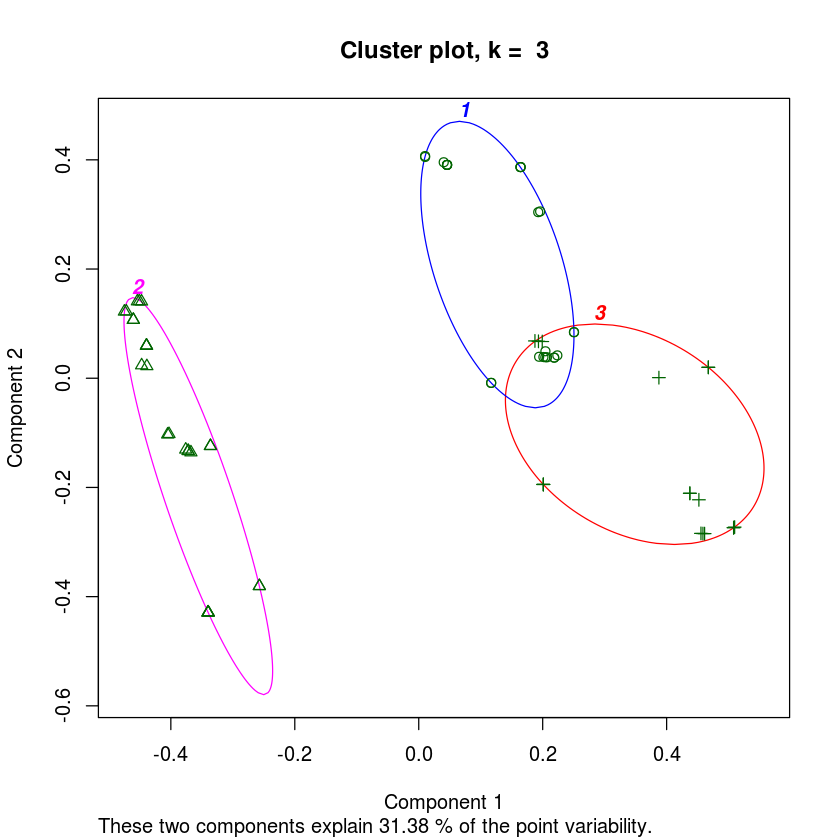

In [41]:
clusplot(pam.patient, main = paste("Cluster plot, k = ", k.patient.optimal), color = TRUE,lines=0,labels=5,span=TRUE,stand=FALSE)

### 3.1.3 Caractérisation des patients médoids

Ci-dessous les 3 patients représentant les 3 classes.

In [42]:
df_pour_clustering[pam.patient$medoids,]

,Age,Comorbidite,Duree_Traitement_Medical,Porteur_Sonde,IPSS,QoL,PSA,Volume_Prostatique,Indication,Anesthesie,Temps_Operation,Delai_Ablation,Caillotage
14,64,0,13,0,29,5,0.18,56,2,1,35,2,0
55,75,0,38,1,35,6,3.70,52,1,1,39,2,0
10,68,0,13,0,20,4,7.84,45,2,2,34,2,0


#### a. Représentant profil 1 (individu no 14)
Le premier représentant est un patient jeune (64 ans et donc sur le premier quartile de la distribution des âges). Il a eu une durée de traitement médical plutôt courte.

Il n'était pas porteur de sonde et pourtant il a un score IPSS de 29 qui signale des sympômes sévères et un score de qualité de vie ressentie haut (5 sachant que 6 est le maximum observé).

Il a très peu d'antigène prostatique dans le sang, montrant un signe positif dans la maladie bénigne de l'adénome de la prostate.

Par contre, il a 1 volume prostatique plus haut que la moyenne (56 alors que la moyenne est de 53 environ).
Il est opéré sous anesthésie loco-régionale, suite à l'échec du traitement médical (indication = 2).

#### b. Représentant profil 2 (individu no 55)
Le deuxième représentant est un patient plus vieux que le premier représentant, 75 ans, sans faire partie des patients les plus âgés. Il est légèrement au dessus de la moyenne qui se situe aux alentours des 71 ans.

Il a eu une durée de traitement au dessus de la moyenne (38 mois). 

Il est porteur de sonde et a donc 1 IPSS et 1 Qol les plus hauts observés. 

Il a 1 taux d'antigène prostatique dans le sang supérieur à la moyenne (3.7 pour 2,7) et un volume prostatique dans la moyenne. 

Il a été opéré sous anesthésie loco-régionale, suite à une rétention vésicale. Sa rétention est d'ailleurs la cause pour laquelle il porte une sonde.

#### c. Représentant profil 3 (individu no 10)

Le troisième représentant est un patient qui a 1 âge correspondant à la médiane des âges de la population globale. Il a eu une durée de traitement médical plutôt courte.

Il ne porte pas de sonde et il a 1 score de qualité de vie relativement bas (4 est le plus petit indice donné en 'QoL' en pré-opératoire), donc un ressenti de qualité de vie moins pire que les autres patients. 

Il a 1 taux d'antigène prostatique dans le sang très élevé (la valeur la plus élevée des observations) et un volume prostatique sous la moyenne. Il a été opéré sous anesthésie générale, suite à l'échec de son traitement médical (indication = 2).

#### d. Tout représentant

- Représentant 1 : jeune / non porteur de sonde / sympômes importants / volume prostatique élevé
- Représentant 2 : âge moyen / porteur de sonde / sympômes importants
- Représentant 3 : âge moyen / non porteur de sonde / PSA élevé

Aucun des représentants ne présente de comorbidité. Le temps d'opération pour chacun est assez proche de la moyenne (38) et loin des minima (13) et maxima (60).

### 3.1.4 Visualisation des distributions du Q_max à 12 mois pour les différentes classes

Notre clustering a été calculé sans la variable 'Technique'. Cela signifie que les profils de patients ne tiennent pas compte de cette information.
Si on ré-intègre cette variable et qu'on affiche leur distribution pour le QMax à 12 mois de chaque cluster, on pourra voir quelle est la technique la plus synonyme de succès selon ce cluster.

In [43]:
# Ajout du cluster aux datasets post-opératoire
rtupb_vbpps_post_clus <- data.frame(rtupb_vbpps_post, pam.patient$clustering)
attributes(rtupb_vbpps_post_clus)$names[23] <- 'patient.cluster'

rtupb_post_clus <- rtupb_vbpps_post_clus[which(rtupb_vbpps_post_clus$Technique == 1),]
vbpps_post_clus <- rtupb_vbpps_post_clus[which(rtupb_vbpps_post_clus$Technique == 2),]

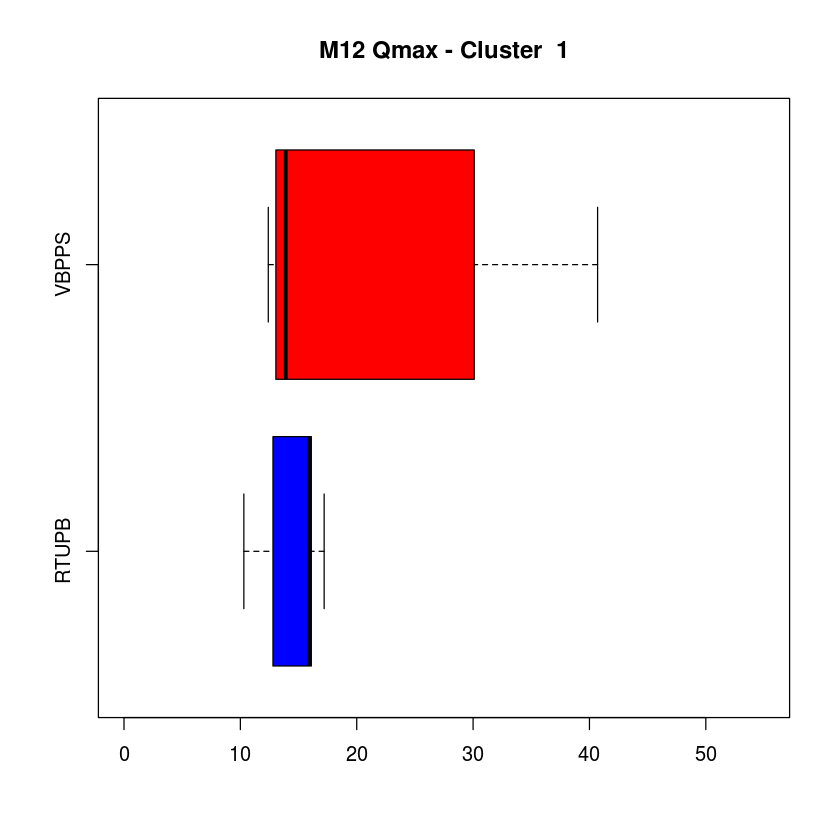

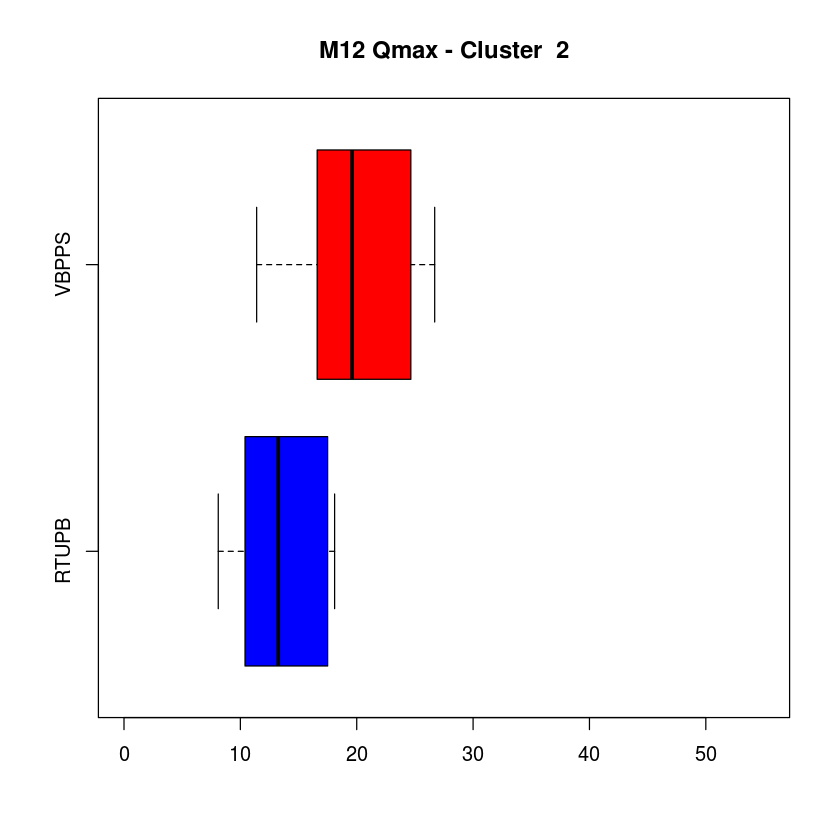

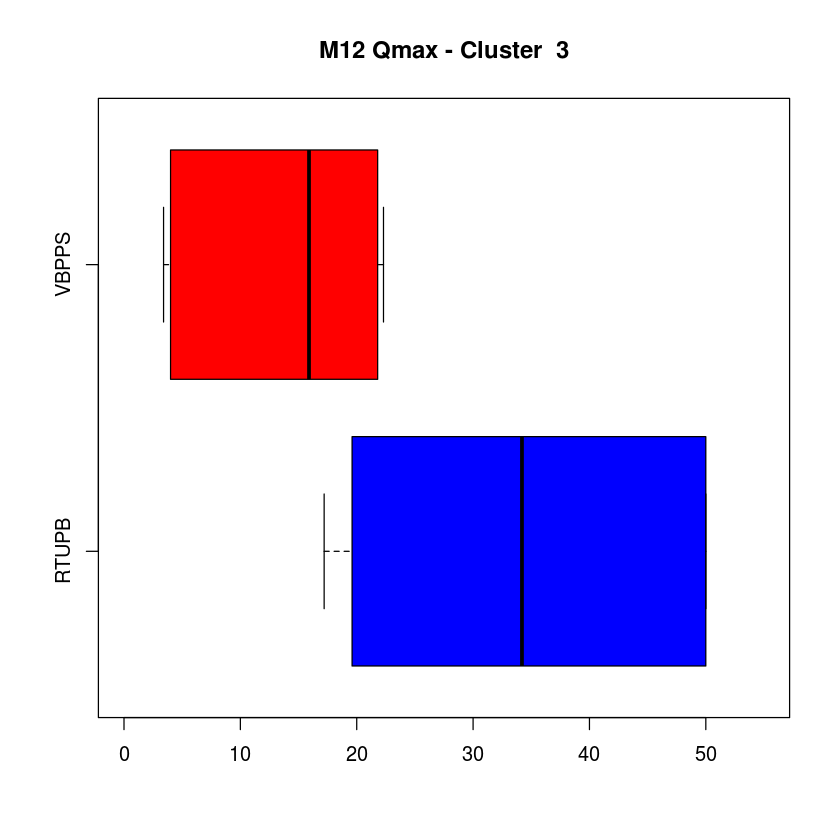

In [44]:
for (i in 1:k.patient.optimal) {
    boxplot(rtupb_post_clus[which(rtupb_post_clus$patient.cluster == i),'M12_Qmax'],
            vbpps_post_clus[which(vbpps_post_clus$patient.cluster == i),'M12_Qmax'],
            names=c("RTUPB","VBPPS"),horizontal=TRUE,main=paste("M12 Qmax - Cluster ", i), col=c("blue","red"),
           ylim=c(0,55))
}

Un individu qui appartiendrait au cluster 3 aurait une miction de meilleure qualité à 12 mois si il a subi la technique RTUPB.
Inversement, un individu qui appartiendrait au cluster 2  ou au cluster 1 aurait une meilleure miction à 12 mois si il subi la technique opératoire VBPPS.

On peut déduire qu'un patient qui aurait les caractéristiques du profil #3 (âge moyen / non porteur de sonde / PSA élevé) devrait être orienté vers la technique RTUPB.

Un patient qui aurait les caractéristiques du profil #1 (jeune / non porteur de sonde / sympômes importants / volume prostatique élevé) ou #2 (âge moyen / porteur de sonde / sympômes importants) devrait être orienté vers la technique opératoire RTUPB.

## 3.2 Extraction des profils types des patients à partir des données post-opératoires¶
### 3.2.1 CAH

A l'aide des séries temporelles crées pour la partie exploratoire, nous créons une matrice qui assemble ces séries temporelles.

On calcule ensuite une matrice de dissimilarités en utilisant la distance euclidienne.

In [45]:
require(cluster)
library(fpc)

# On crée une matrice de séries temporelles
df_series = as.data.frame(cbind(t(rtupb_vbpps_post_series_ipss),t(rtupb_vbpps_post_series_QoL),t(rtupb_vbpps_post_series_qmax)))

# On crée notre matrice de dissimilarité avec distance euclidienne
euclidean_dist = dist(df_series, method = "euclidean")
attributes(df_series)$names = c("M1_IPSS","M3_IPSS","M6_IPSS","M9_IPSS","M12_IPSS","M15_IPSS","M18_IPSS",
                                "M1_QoL","M3_QoL","M6_QoL","M9_QoL","M12_QoL","M15_QoL","M18_QoL",
                                "M1_Qmax","M3_Qmax","M6_Qmax","M9_Qmax","M12_Qmax","M15_Qmax","M18_Qmax"
                               )

summary(euclidean_dist)
euclidean_mat <- as.matrix(euclidean_dist)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   12.77   23.13   32.55   46.56  126.02 

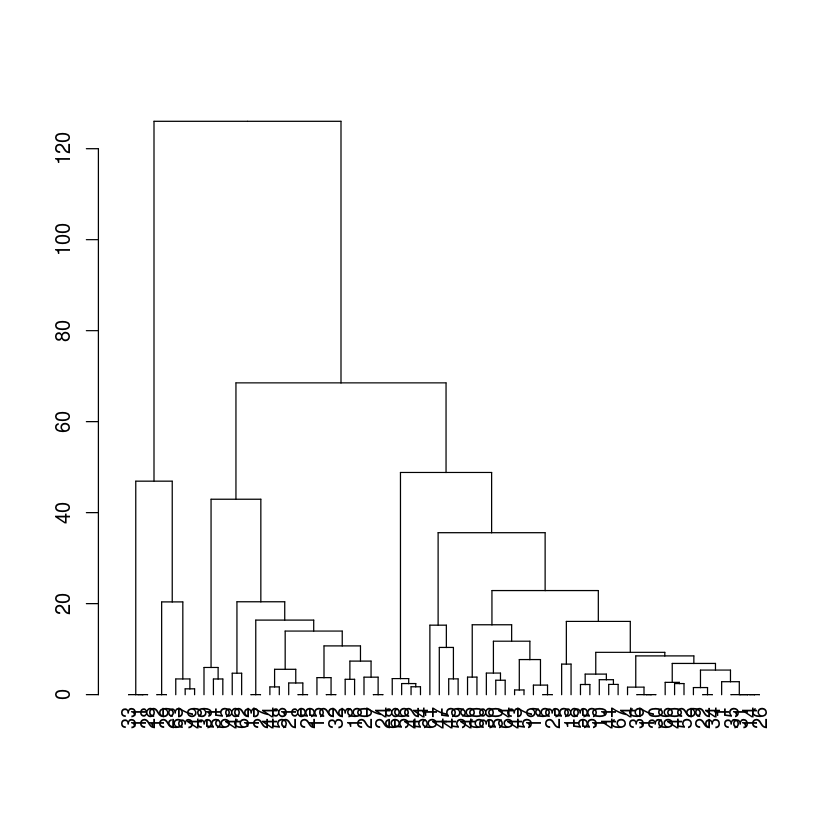

In [46]:
## Tracé du dendrogramme
cah_post_op <- hclust(euclidean_dist)
plot(as.dendrogram(cah_post_op))

En regardant le dendrogramme, nous pouvons évaluer un nombre de classes de 2 ou 3.

### 3.2.2 PAM

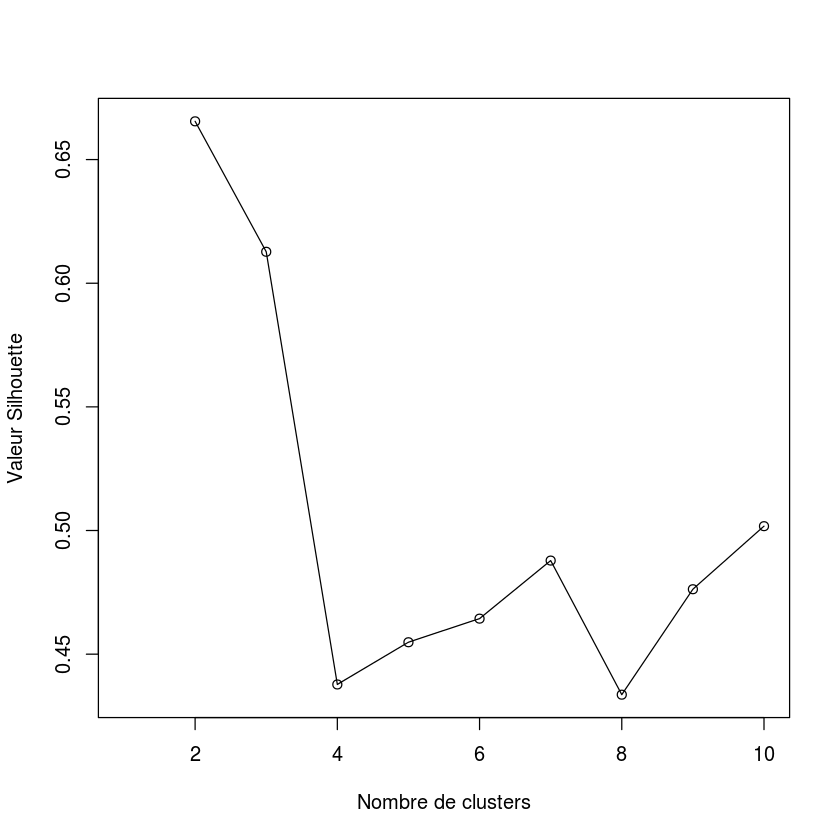

In [47]:
# Calculate silhouette width for many k using PAM
sil_width <- c(NA)

for(i in 2:10){
  pam_test <- pam(euclidean_dist, diss = TRUE, k = i)
  sil_width[i] <- pam_test$silinfo$avg.width
}

# Plot sihouette width (higher is better)
plot(1:10, sil_width, xlab = "Nombre de clusters", ylab = "Valeur Silhouette")
lines(1:10, sil_width)

Les valeurs silhouette justifieraient plutôt de faire le choix de 2 profils. Avec 3 profils, la valeur silhouette reste assez haute. Au delà, les valeurs sont mauvaises. L'intuition que nous avons eue avec le dendrogramme est vérifiée.

Ci-dessous le graphique avec 2 classes.

size,max_diss,av_diss,diameter,separation
60,44.29086,15.21593,68.52707,21.16955
8,34.02999,18.07269,46.91716,21.16955


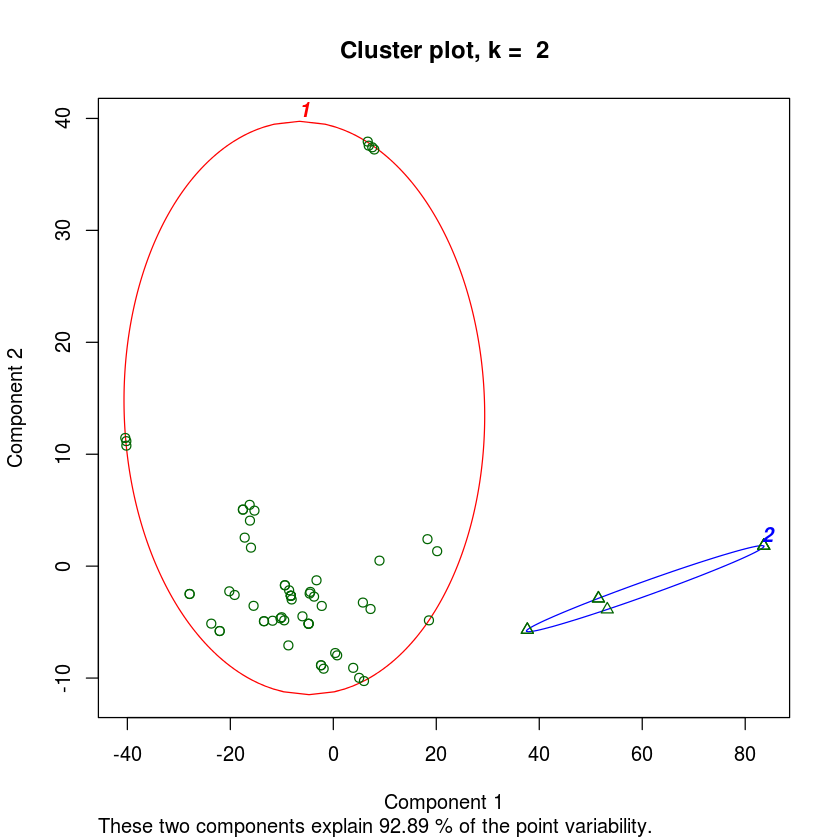

In [48]:
k.guerison.optimal = 2

pam.guerison <- pam(euclidean_dist, diss = TRUE, k = k.guerison.optimal, metric = "euclidean")
pam.guerison$clusinfo

clusplot(pam.guerison, main = paste("Cluster plot, k = ", k.guerison.optimal), color = TRUE,lines=0,labels=5,span=TRUE,stand=FALSE)

En prenant 2 clusters, il nous semble que l'on intègre au premier cluster quelques valeurs qui pourraient former leur propre groupe. Si on essaye avec 3 groupes, cette intuition est confirmée ci-dessous. Les individus isolés forment bien le troisième cluster.

size,max_diss,av_diss,diameter,separation
56,44.290857,13.218910,68.527075,21.16955
8,34.029987,18.072695,46.917161,21.16955
4,2.964793,1.783514,3.525621,37.46345


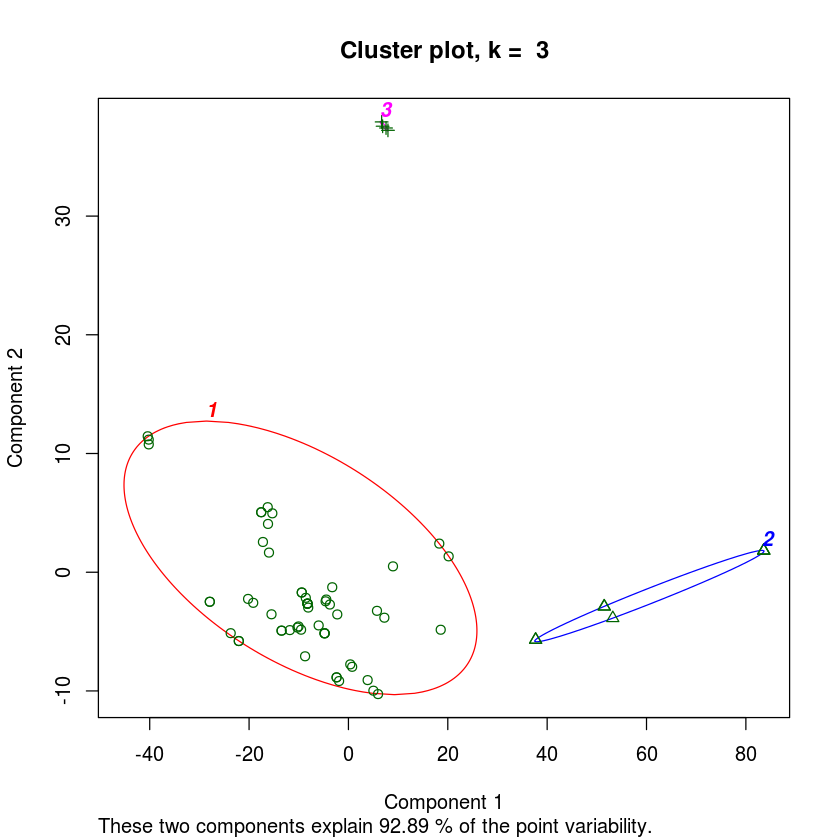

In [70]:
k.guerison.optimal = 3

pam.guerison <- pam(euclidean_dist, diss = TRUE, k = k.guerison.optimal, metric = "euclidean")
pam.guerison$clusinfo

clusplot(pam.guerison, main = paste("Cluster plot, k = ", k.guerison.optimal), color = TRUE,lines=0,labels=5,span=TRUE,stand=FALSE)

La distribution des groupes n'est pas homogène, avec 2 ou 3 groupes. En effet le premier groupe est très peuplé. 

Nous faisons finalement le choix de partir avec 3 profils de guérison.

### 3.2.3 Caractérisation des profils de guérison médoids

In [81]:
df_series[pam.guerison$medoids,1:7]
df_series[pam.guerison$medoids,8:14]
df_series[pam.guerison$medoids,15:21]

,M1_IPSS,M3_IPSS,M6_IPSS,M9_IPSS,M12_IPSS,M15_IPSS,M18_IPSS
9,6,2,2,2,2,2,2
49,6,2,1,1,1,1,1
42,9,6,3,3,3,3,3


,M1_QoL,M3_QoL,M6_QoL,M9_QoL,M12_QoL,M15_QoL,M18_QoL
9,3,2,2,2,2,2,2
49,3,2,1,1,1,1,1
42,3,3,1,1,1,1,1


,M1_Qmax,M3_Qmax,M6_Qmax,M9_Qmax,M12_Qmax,M15_Qmax,M18_Qmax
9,12.4,15.7,14.9,15.1,15.1,16.0,16.0
49,38.4,28.9,39.6,40.1,39.4,39.2,39.0
42,50.0,35.0,12.0,12.3,12.4,12.8,12.9


#### a. Représentant profil 1 (individu no 9)

Cet individu a 1 IPSS à 6 au premier mois, IPSS 'peu symptomatique'. Il se stabilise rapidement à 2 au bout du troisième mois. 

Son score de qualité de vie commence à 3 (équivalent aux autres profils) passe à 2 au bout du troisième mois pour ne plus bouger. Il reste plus haut que les scores des autres profils.

Son Qmax est à 12.4 au premier mois et atteint 16 au 18eme mois après une chute au 6eme mois.

#### b. Représentant profil 2 (individu no 49)

Le second profil a un IPSS 'Peu symptomatique' de 6 au premier mois qui descend à 2 au troisième mois. Et se stabilise à 1 à partir du 6eme mois.

Son score de qualité de vie commence à 3, descend à 2 au troisième mois. Et se stabilise à 1 au 6ème mois.

Le Qmax est à 38.4 au premier mois. Il évolue peu au cours du temps. Il termine à 39 au 18ème mois.

#### c. Représentant profil 3 (individu no 42)

Il a 1 score IPSS au premier mois plus haut que les autres profils. Cette valeur place le profil dans la classe 'Modérément symptomatique' montrant qu'il reste encore des symptomes au premier mois après l'opération. L'indice atteint sa valeur plancher et stabilisée à 3 au bout du sixième mois. Son score IPSS reste le plus haut des 3 profils.

L'indice QoL atteint sa valeur plancher 1 au sixième mois.

Enfin, son Qmax commence plus haut que les autres profils, chute au 3eme et 6mois pour atteindre la valeur de 12. Valeur qui remonte doucement jusqu'à 12.9 pour le 18eme mois. La valeur finale de l'indice reste plus basse que les autres profils. Le patient aura une moins bonne miction après le 18ème mois.

## 3.3 Classification supervisée

### 3.3.1 Arbres de régression

Tous nos arbres sont des arbres de régression car ils prédisent des variables quantitatives, y compris la variable "QoL" que nous avons choisi de traiter comme numérique malgré qu'elle soit réellement de type "ordinal".

#### a. IPSS

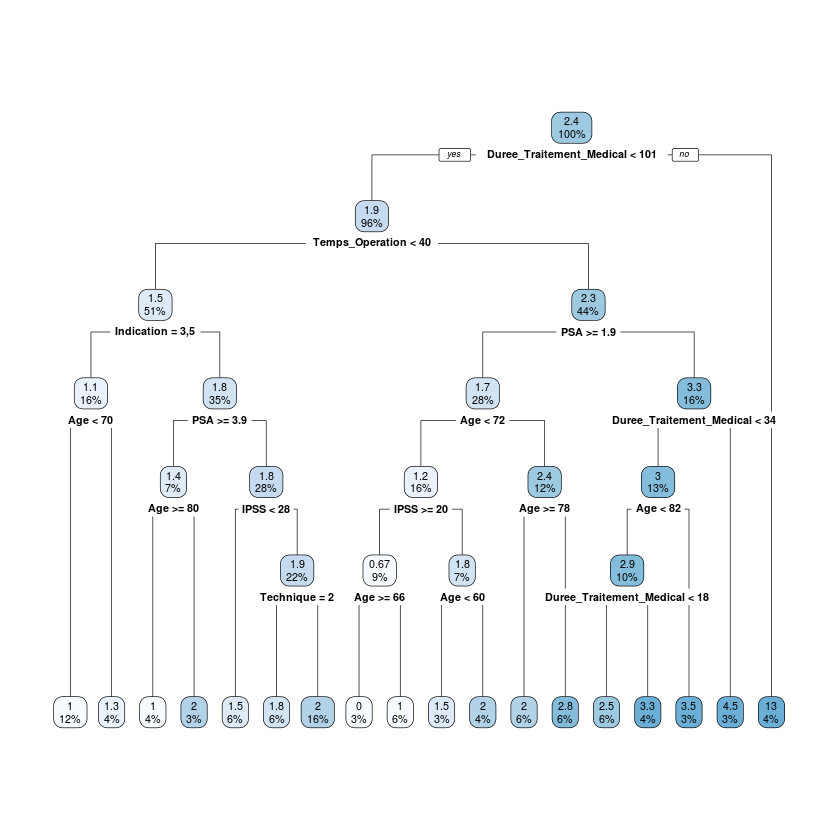

In [52]:
# Calcul de l'arbre

ipss = subset(rtupb_vbpps_post, select = c(M12_IPSS))
matrix_for_tree_ipss = cbind(rtupb_vbpps_pre, ipss)

tree_ipss = rpart(method = "anova", formula = matrix_for_tree_ipss$M12_IPSS ~.,data=matrix_for_tree_ipss,control=rpart.control(minsplit=5,cp=0))

pSimple <- prune(tree_ipss,cp=0)

# Plot de l'arbre
rpart.plot(pSimple)

On retrouve les variables "Durée traitement médical" et "Temps opération" comme critères important de ségrégation. Ce sont 2 variables que nous avions noté d'importance dans la partie analyse exploratoire.

Pour évaluer la performance de l'arbre, nous générons une prédiction pour 10 individus pris au hasard et nous les comparons avec les valeurs réelles observées. Ci-dessous les résultats :

In [53]:
# Evaluation de la performance de l'arbre avec 10 individus tirés au hasard
rnd_individus = sample(1:nrow(matrix_for_tree_ipss), 10)
df <- data.frame(predict(pSimple,matrix_for_tree_ipss[rnd_individus,]), matrix_for_tree_ipss[rnd_individus,15])
colnames(df) <- c("Prédiction","Observé")
df

,Prédiction,Observé
65,13.000000,13
33,1.000000,1
59,0.000000,0
60,3.333333,4
39,13.000000,13
26,2.000000,2
10,2.000000,2
58,3.333333,3
19,1.000000,1
4,2.000000,2


#### b. QMax

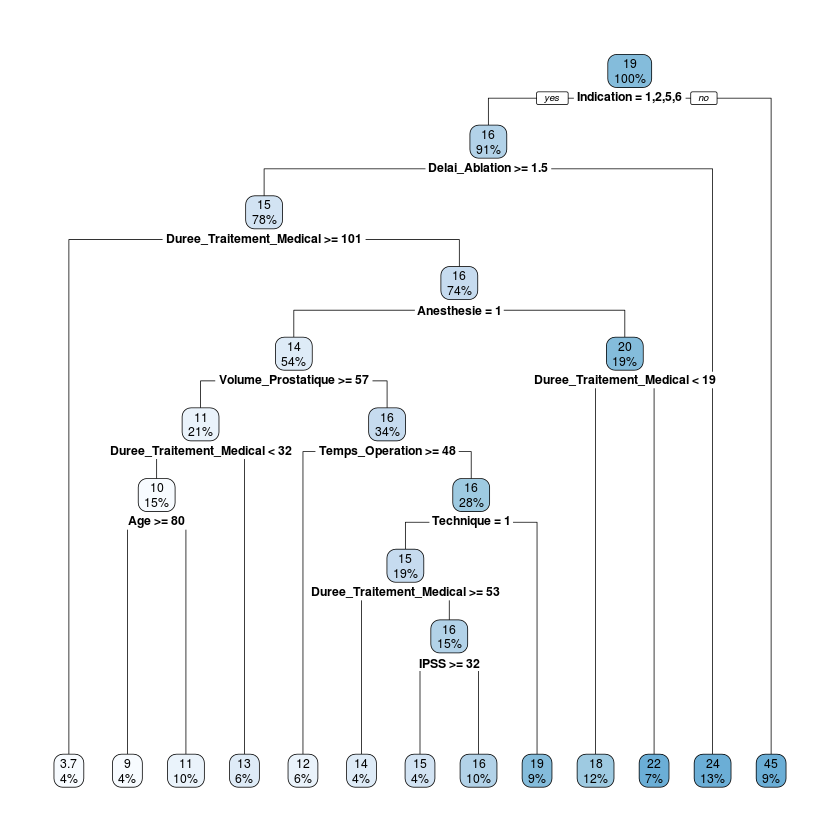

In [54]:
# Calcul de l'arbre
qmax = subset(rtupb_vbpps_post, select = c(M12_Qmax))
matrix_for_tree_qmax = cbind(rtupb_vbpps_pre, qmax)

tree_qmax = rpart(method = "anova", formula = matrix_for_tree_qmax$M12_Qmax ~.,data=matrix_for_tree_qmax,control=rpart.control(minsplit=10,cp=0))

pSimple <- prune(tree_qmax,cp=0)

# Plot de l'arbre
rpart.plot(pSimple)

Pour évaluer la performance de l'arbre, nous générons une prédiction pour 10 individus pris au hasard et nous les comparons avec les valeurs réelles observées. Ci-dessous les résultats :

In [55]:
# Evaluation de la performance de l'arbre avec 10 individus tirés au hasard
rnd_individus = sample(1:nrow(matrix_for_tree_qmax), 10)
df <- data.frame(predict(pSimple,matrix_for_tree_qmax[rnd_individus,]), matrix_for_tree_qmax[rnd_individus,15])
colnames(df) <- c("Prédiction","Observé")
df

,Prédiction,Observé
22,15.10000,15.1
48,12.45000,12.6
18,16.20000,15.9
39,3.70000,3.4
31,16.20000,16.1
17,18.50000,18.1
36,18.50000,18.1
56,12.92500,13.2
55,18.56667,18.8
63,44.76667,40.7


#### c. QoL

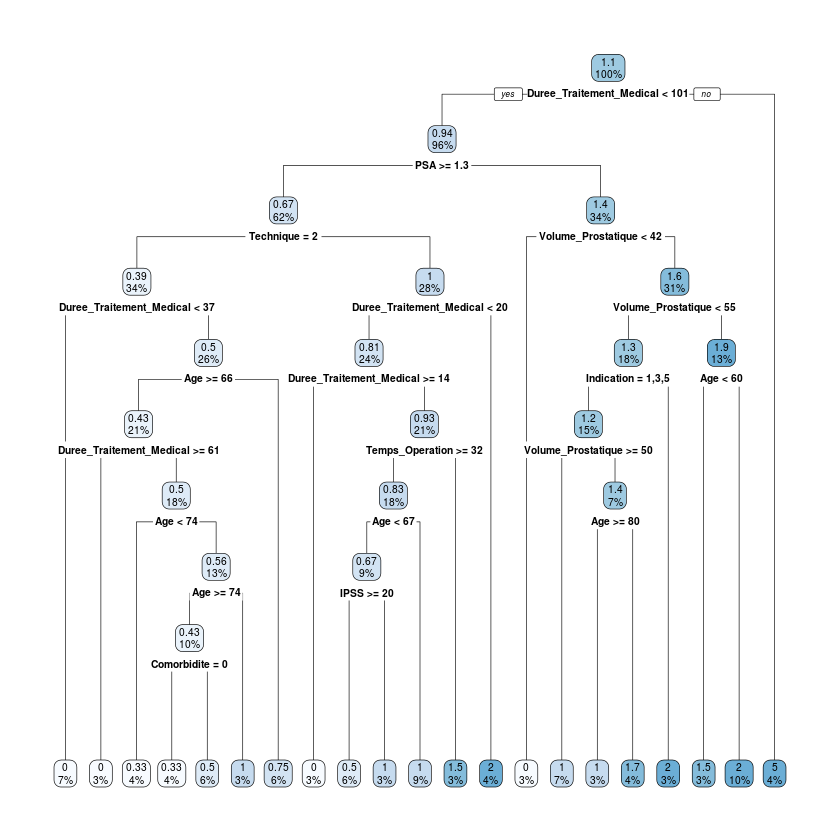

In [56]:
# Calcul de l'arbre
qol = subset(rtupb_vbpps_post, select = c(M12_QoL))
matrix_for_tree_qol = cbind(rtupb_vbpps_pre, qol)

tree_qol = rpart(method = "anova", formula = matrix_for_tree_qol$M12_QoL ~.,data=matrix_for_tree_qol,control=rpart.control(minsplit=5, cp=0))

pSimple <- prune(tree_qol,cp=0)

# Plot de l'arbre
rpart.plot(pSimple)

Pour évaluer la performance de l'arbre, nous générons une prédiction pour 10 individus pris au hasard et nous les comparons avec les valeurs réelles observées. Ci-dessous les résultats :

In [57]:
# Evaluation de la performance de l'arbre avec 10 individus tirés au hasard
rnd_individus = sample(1:nrow(matrix_for_tree_qol), 10)
df <- data.frame(predict(pSimple,matrix_for_tree_qol[rnd_individus,]), matrix_for_tree_qol[rnd_individus,15])
colnames(df) <- c("Prédiction","Observé")
df

,Prédiction,Observé
60,1.6666667,2
63,0.7500000,0
59,0.3333333,1
44,1.0000000,1
61,0.3333333,0
33,1.0000000,1
36,2.0000000,2
21,1.0000000,1
64,0.7500000,1
2,1.0000000,1


### 3.3.2 Prédiction de la classe de guérison

L'idée ici est de reprendre la classification de guérison trouvée en partie 3.2 et de créer un arbre de décision basé sur les variables pré-opératoire permettant de prédire cette classification.
On parlera d'arbre de classification car la variable à prédire est une classe (variable qualitative donc).

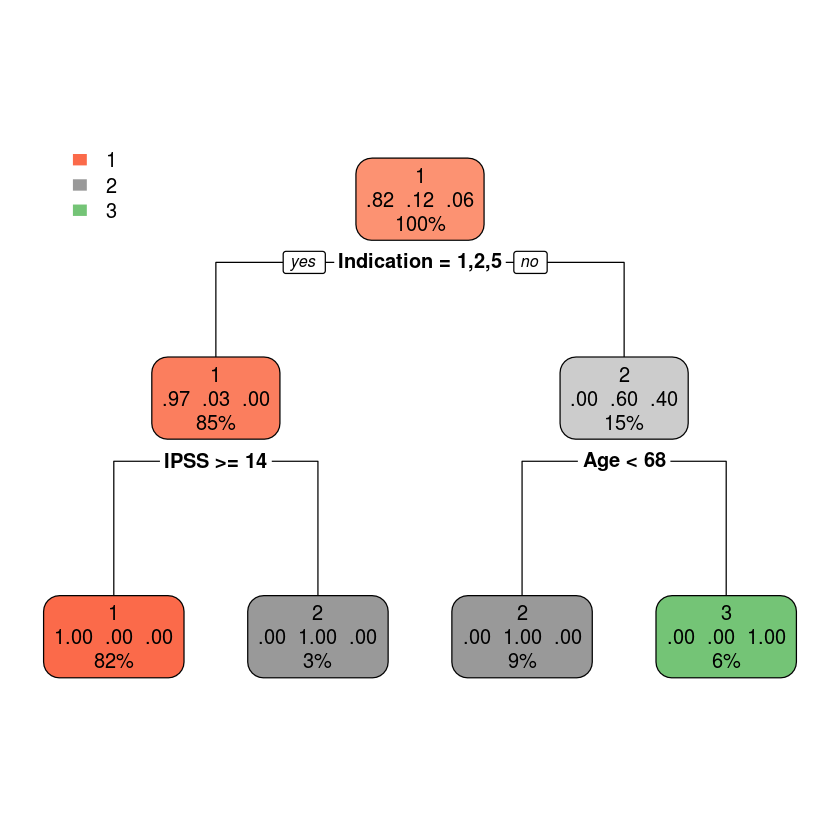

In [58]:
# Calcul de l'arbre
Profil_Guerison <- pam.guerison$clustering
matrix_for_tree_guerison = cbind(rtupb_vbpps_pre, Profil_Guerison)

tree_guerison = rpart(method = "class", formula = matrix_for_tree_guerison$Profil_Guerison ~.,data=matrix_for_tree_guerison,control=rpart.control(minsplit=5,cp=0))

pSimple <- prune(tree_guerison,cp=0)

# Plot de l'arbre
rpart.plot(pSimple)

Pour évaluer la performance de l'arbre, nous générons une prédiction pour 10 individus pris au hasard et nous les comparons avec les valeurs réelles observées. Ci-dessous les résultats :

In [59]:
# Evaluation de la performance de l'arbre avec 10 individus tirés au hasard

rnd_individus = sample(1:nrow(matrix_for_tree_guerison), 10)

# Calcul de la prédiction
p <- predict(pSimple,matrix_for_tree_guerison[rnd_individus,])
# et facilitation de la lecture de prédiction
p[p == 1] <- 'X'

res <- cbind(matrix_for_tree_guerison[rnd_individus,15], p)
colnames(res) <- c("Observé", "Prédiction classe = 1", "Prédiction classe = 2", "Prédiction classe = 3")
res

,Observé,Prédiction classe = 1,Prédiction classe = 2,Prédiction classe = 3
44,1,X,0,0
68,3,0,0,X
65,1,X,0,0
27,1,X,0,0
8,1,X,0,0
34,1,X,0,0
14,1,X,0,0
30,1,X,0,0
23,1,X,0,0
59,1,X,0,0
